# QB Pressure Component Analysis & Baseline Model Evaluation

This notebook analyzes defensive pressure components and evaluates their predictive power for pass outcomes using 3-way classification (Negative/Neutral/Positive plays).

**Key Components:**
- **Data Preparation:** Creates binary (y_incomplete) and 3-way (y_outcome) targets; groups routes into SHORT/INTERMEDIATE/DEEP
- **Descriptive Analysis:** Feature distributions, correlations, and outcome relationships across route types
- **Baseline Models:** Evaluates individual features, pairwise combinations, and combined models using Logistic Regression & Random Forest
- **Route-Stratified Analysis:** Separate model evaluation within each route group with coefficient significance testing

**Pass Outcome Definitions:**
- **y_incomplete (Binary Classification):**
    - 0 = Complete (C)
    - 1 = Incomplete/Intercepted (I, IN)
- **y_outcome (3-Way Classification):**
    - 0 = Negative Play (Incomplete or ≤0 yards)
    - 1 = Neutral Play (Complete with 1-4 yards)
    - 2 = Positive Play (Complete with 5+ yards)

**Route Type Groupings:**
- **SHORT:** HITCH, SLANT, SCREEN, FLAT, WHEEL
- **INTERMEDIATE:** OUT, IN, CROSS, ANGLE
- **DEEP:** GO, POST, CORNER

**Evaluation Metrics:**
- ROC AUC (One-vs-Rest & One-vs-One)
- Precision-Recall curves
- Confusion matrices and classification reports
- Permutation feature importances
- Model coefficients with p-values

**Outputs:** All figures saved to `figures/` directory with comprehensive visualizations including distributions, boxplots, ROC curves, and heatmaps.


In [18]:
%matplotlib inline
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    auc,
    roc_curve,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.inspection import permutation_importance
from scipy.stats import spearmanr

warnings.filterwarnings('ignore')
sns.set(style='whitegrid')


In [19]:
# Configuration
DATA_PATH = Path("data/output/final_ml_features_with_component_scores.csv")
FIG_DIR = Path("figures")
FIG_DIR.mkdir(exist_ok=True, parents=True)
RANDOM_STATE = 42
N_SPLITS = 5

# Add this flag to control plot display
SHOW_PLOTS = True  # Set to False if you only want to save plots

pressure_components = [
    "convergence_pressure_score",
    "velocity_pressure_score",
    "tr_coverage_pressure_score",
]
# Labels considered as incomplete/intercepted (adjust if needed)
label_values_incomplete = {"I", "IN"}


In [21]:

def load_and_prepare(path: Path):
    """
    Load CSV and prepare target variables for classification.
    
    Creates two target variables:
    1. y_incomplete: Binary classification (Complete vs Incomplete/Intercepted)
    2. y_outcome: 3-way classification based on pass result and yards gained
    
    Parameters
    ----------
    path : Path
        Path to the CSV file containing QB pressure data
        
    Returns
    -------
    pd.DataFrame
        Prepared dataframe with target variables and cleaned data
        
    """
    if not path.exists():
        raise FileNotFoundError(f"Data file not found: {path}")
    
    # Load data and create working copy
    df = pd.read_csv(path)
    df = df.copy()
    
    # Create binary target: y_incomplete
    # 1 = Incomplete/Intercepted (I, IN)
    # 0 = Complete (C)
    df["y_incomplete"] = df["pass_result"].apply(
        lambda x: 1 if str(x) in label_values_incomplete else 0
    )
    
    # Create 3-way outcome variable: y_outcome
    # Extract required columns for vectorized operations
    is_complete = (df['pass_result'] == 'C')
    yards = df['yards_gained'].fillna(0)  # Handle missing yards_gained values
    
    # Vectorized classification logic:
    # - Start with all zeros (Negative Play by default)
    # - Add 1 for Neutral plays (complete with 1-4 yards)
    # - Add 2 for Positive plays (complete with 5+ yards)
    df["y_outcome"] = (
        (is_complete & (yards >= 5)).astype(int) * 2 +  # Positive Play: value = 2
        (is_complete & (yards >= 1) & (yards <= 4)).astype(int)  # Neutral Play: value = 1
        # Negative Play (incomplete OR complete with ≤0 yards): value = 0 (default)
    )
    
    # Drop rows with missing values in pressure components or target variables
    df = df.dropna(subset=pressure_components + ["y_outcome", "y_incomplete"])
    
    # Display outcome distributions for validation
    print("\n3-Way Outcome Distribution:")
    print(df["y_outcome"].value_counts().sort_index())
    print(f"  0 (Negative Play): {(df['y_outcome'] == 0).sum()} plays - Incomplete or ≤0 yards")
    print(f"  1 (Neutral Play):  {(df['y_outcome'] == 1).sum()} plays - Complete with 1-4 yards")
    print(f"  2 (Positive Play): {(df['y_outcome'] == 2).sum()} plays - Complete with 5+ yards")
    
    print("\nBinary Classification (y_incomplete) Distribution:")
    print(f"  0 (Complete): {(df['y_incomplete'] == 0).sum()} plays")
    print(f"  1 (Incomplete/Intercepted): {(df['y_incomplete'] == 1).sum()} plays")

    # Gropuing route types for potential further analysis
    # Group 1 SHORT : HITCH, SLANT, SCREEN, FLAT, WHEEL
    # Group 2 INTERMEDIATE : OUT, IN, CROSS, ANGLE
    # Group 3 DEEP : GO, POST, CORNER
    route_type_mapping = {
        'HITCH': 'SHORT',
        'SLANT': 'SHORT',
        'SCREEN': 'SHORT',
        'FLAT': 'SHORT',
        'WHEEL': 'SHORT',
        'OUT': 'INTERMEDIATE',
        'IN': 'INTERMEDIATE',
        'CROSS': 'INTERMEDIATE',
        'ANGLE': 'INTERMEDIATE',
        'GO': 'DEEP',
        'POST': 'DEEP',
        'CORNER': 'DEEP'
    }
    df['route_type'] = df['route_of_targeted_receiver'].map(route_type_mapping)

    # Display route type distribution
    print("\nRoute Type Distribution:")
    print(df['route_type'].value_counts().sort_index())
    print(f"\nMissing route_type values: {df['route_type'].isna().sum()}")

    return df

## Prepare Data


3-Way Outcome Distribution:
y_outcome
0    4648
1    1471
2    7986
Name: count, dtype: int64
  0 (Negative Play): 4648 plays - Incomplete or ≤0 yards
  1 (Neutral Play):  1471 plays - Complete with 1-4 yards
  2 (Positive Play): 7986 plays - Complete with 5+ yards

Binary Classification (y_incomplete) Distribution:
  0 (Complete): 9737 plays
  1 (Incomplete/Intercepted): 4368 plays

Route Type Distribution:
route_type
DEEP            2675
INTERMEDIATE    5359
SHORT           6069
Name: count, dtype: int64

Missing route_type values: 2
Loaded data shape: (14105, 46)
Label counts:
 y_incomplete
0    9737
1    4368
Name: count, dtype: int64


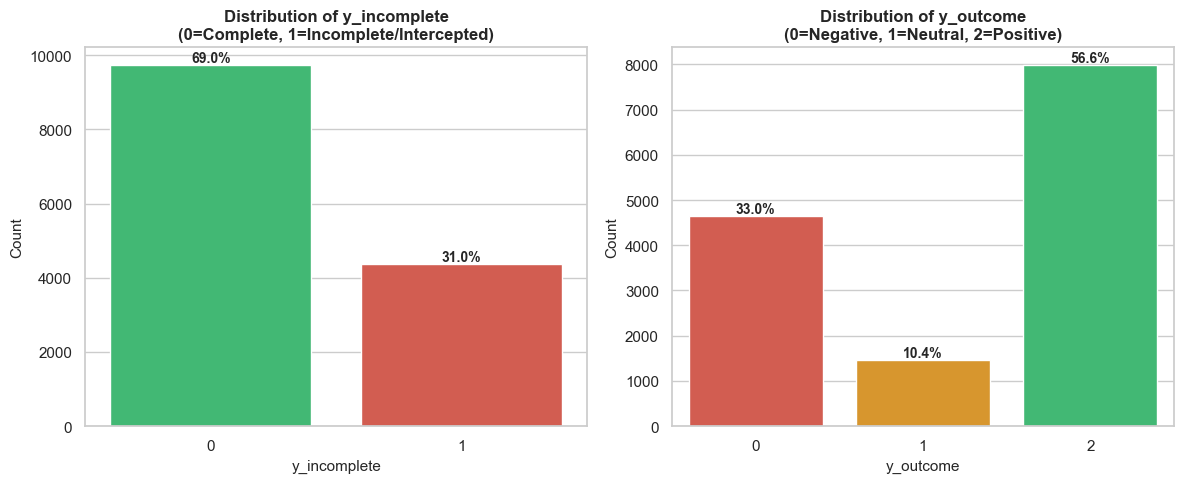

In [17]:
df = load_and_prepare(DATA_PATH)
print("Loaded data shape:", df.shape)
print("Label counts:\n", df["y_incomplete"].value_counts())

# Plot distributions of outcome variables. Add colors to catagories for clarity. Display % on bars.
# Do not use one-hot encoding on these categorical target variables.
# Define color palettes for clarity

# Define color palettes for clarity
incomplete_colors = ['#2ecc71', '#e74c3c']  # Green for complete (0), Red for incomplete (1)
outcome_colors = ['#e74c3c', '#f39c12', '#2ecc71']  # Red for negative (0), Orange for neutral (1), Green for positive (2)

plt.figure(figsize=(12, 5))

# Plot y_incomplete distribution
plt.subplot(1, 2, 1)
ax1 = sns.countplot(x="y_incomplete", data=df, palette=incomplete_colors)
plt.title("Distribution of y_incomplete\n(0=Complete, 1=Incomplete/Intercepted)", fontsize=12, fontweight='bold')
plt.xlabel("y_incomplete", fontsize=11)
plt.ylabel("Count", fontsize=11)

# Add percentage labels on bars
total = len(df)
for p in ax1.patches:
    height = p.get_height()
    percentage = f'{100 * height / total:.1f}%'
    ax1.text(p.get_x() + p.get_width()/2., height, 
             percentage, ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot y_outcome distribution
plt.subplot(1, 2, 2)
ax2 = sns.countplot(x="y_outcome", data=df, palette=outcome_colors)
plt.title("Distribution of y_outcome\n(0=Negative, 1=Neutral, 2=Positive)", fontsize=12, fontweight='bold')
plt.xlabel("y_outcome", fontsize=11)
plt.ylabel("Count", fontsize=11)

# Add percentage labels on bars
for p in ax2.patches:
    height = p.get_height()
    percentage = f'{100 * height / total:.1f}%'
    ax2.text(p.get_x() + p.get_width()/2., height, 
             percentage, ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(FIG_DIR / "outcome_distributions.png", dpi=300, bbox_inches='tight')

if SHOW_PLOTS:
    plt.show()
else:
    plt.close()


## Feature Distributions and Correlations


SUMMARY STATISTICS FOR ALL PRESSURE COMPONENTS
                 Component  Count      Mean       Std  Min  25%  Median  75%   Max
Convergence Pressure Score  14105 13.440369 25.348159  0.0  0.0     0.0 33.3 100.0
   Velocity Pressure Score  14105  5.556519  9.230769  0.0  0.0     1.3  7.3  69.3
Tr Coverage Pressure Score  14105 67.476717 25.266342  0.0 52.5    76.0 88.1 100.0


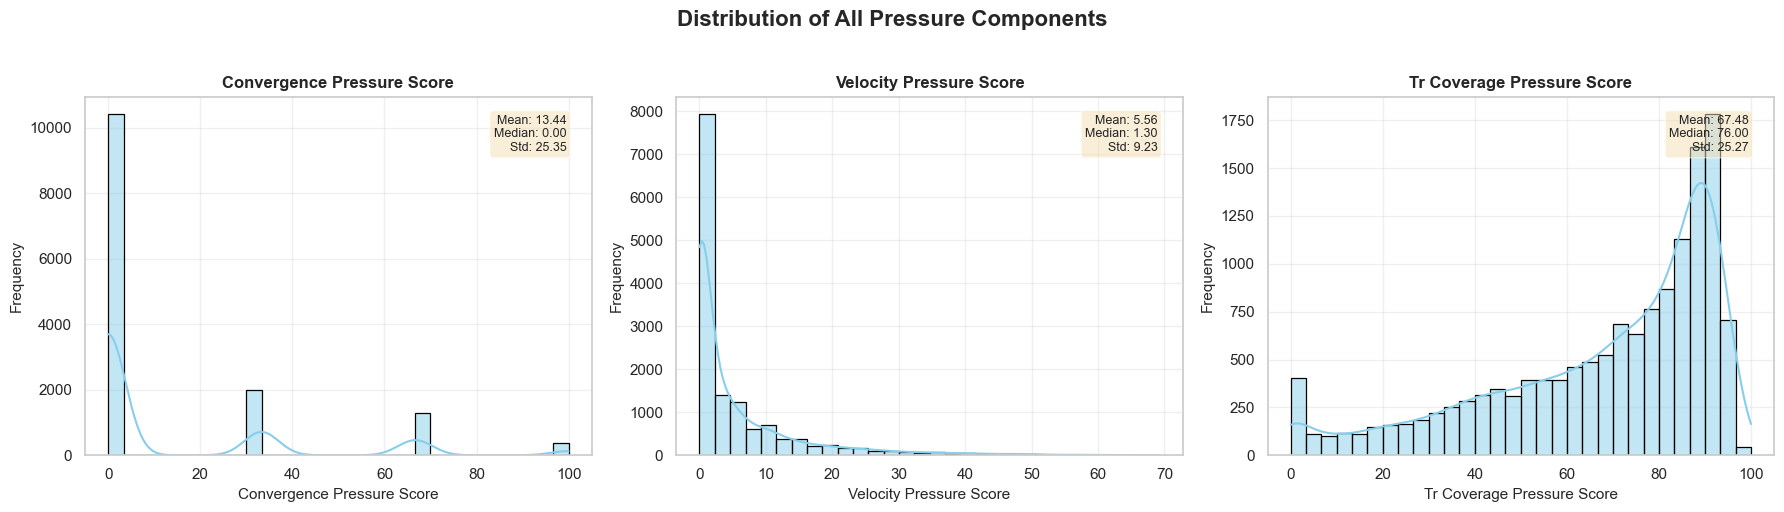

In [22]:
# For each pressure_components i.e. feature, calculate:
# Feature 1 (Receiver Coverage)
# Frequency table (if categorical: Open/Tight/Covered)
# OR summary stats (if continuous: min, max, mean, median)
# Feature 2 (QB-Defender Distance)
# Min, max, mean, median, quartiles
# Histogram to check distribution shape
# Feature 3 (Defender Velocity)
# Min, max, mean, median, quartiles
# Histogram to check distribution shape
# First, display summary statistics for all components together
print("\n" + "="*80)
print("SUMMARY STATISTICS FOR ALL PRESSURE COMPONENTS")
print("="*80)

summary_stats = []
for component in pressure_components:
    data = df[component].dropna()
    stats = {
        'Component': component.replace('_', ' ').title(),
        'Count': len(data),
        'Mean': data.mean(),
        'Std': data.std(),
        'Min': data.min(),
        '25%': data.quantile(0.25),
        'Median': data.median(),
        '75%': data.quantile(0.75),
        'Max': data.max()
    }
    summary_stats.append(stats)
    
    # print(f"\n--- {component} ---")
    # print(data.describe())

# Create a summary dataframe
summary_df = pd.DataFrame(summary_stats)
print(summary_df.to_string(index=False))

# Now, plot all features together in a grid
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Distribution of All Pressure Components', fontsize=16, fontweight='bold', y=1.02)

for idx, component in enumerate(pressure_components):
    data = df[component].dropna()
    
    sns.histplot(data, bins=30, kde=True, color='skyblue', edgecolor='black', ax=axes[idx])
    axes[idx].set_title(f'{component.replace("_", " ").title()}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(component.replace('_', ' ').title(), fontsize=11)
    axes[idx].set_ylabel('Frequency', fontsize=11)
    axes[idx].grid(True, alpha=0.3)
    
    # Add summary stats as text on plot
    axes[idx].text(0.95, 0.95, f'Mean: {data.mean():.2f}\nMedian: {data.median():.2f}\nStd: {data.std():.2f}',
                   transform=axes[idx].transAxes, fontsize=9,
                   verticalalignment='top', horizontalalignment='right',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(FIG_DIR / "all_pressure_components_distribution.png", dpi=300, bbox_inches='tight')

if SHOW_PLOTS:
    plt.show()
else:
    plt.close()

## Feature vs. Outcome Analysis

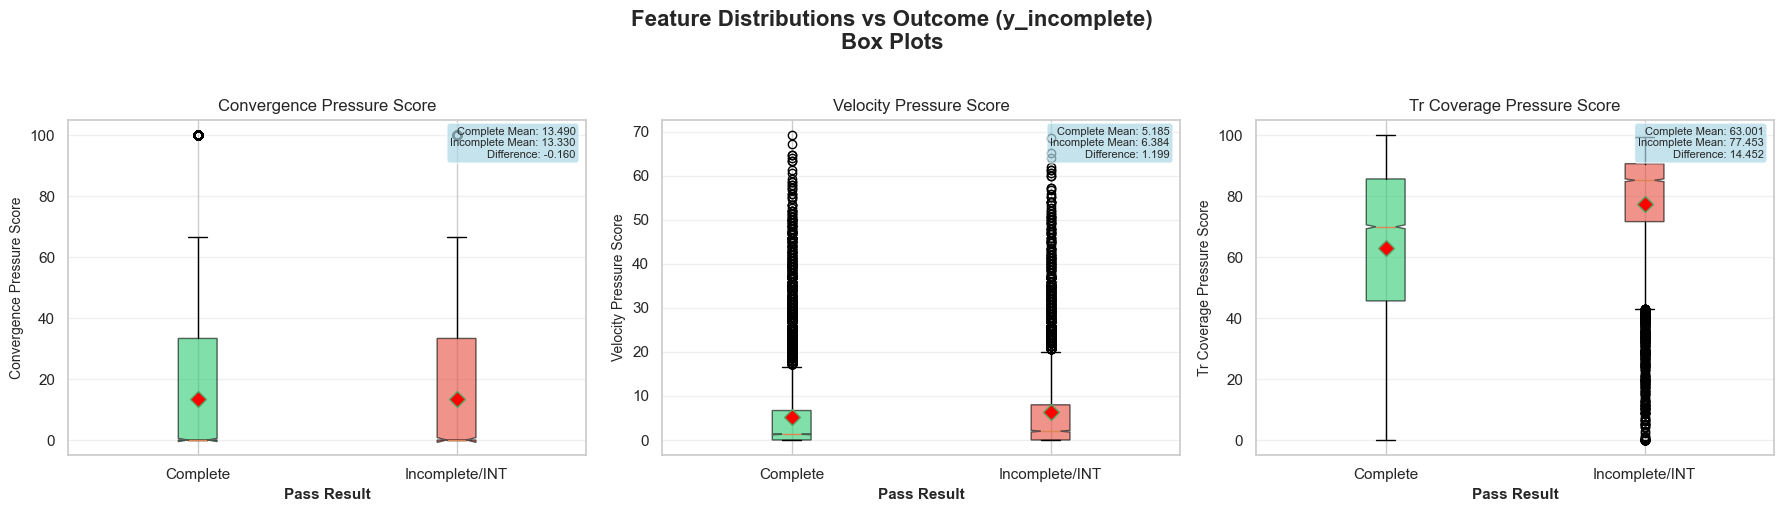

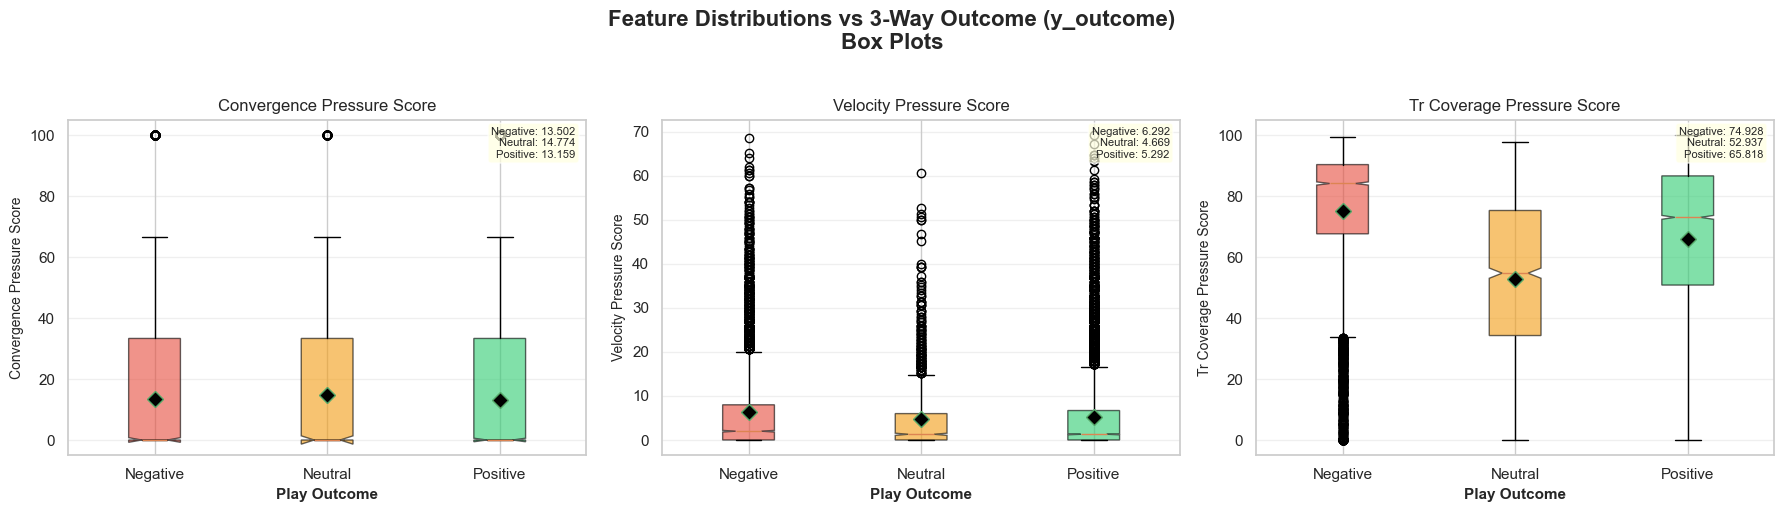

In [23]:
# Feature Distribution vs Outcome Analysis
# Create scatter plots and box plots for all pressure components vs outcome variables

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

# --- BOX PLOTS: All Features vs y_incomplete ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Feature Distributions vs Outcome (y_incomplete)\nBox Plots', 
             fontsize=16, fontweight='bold', y=1.02)

for idx, component in enumerate(pressure_components):
    # Create box plot grouped by outcome
    box_data = [
        df[df['y_incomplete'] == 0][component].dropna(),
        df[df['y_incomplete'] == 1][component].dropna()
    ]
    
    bp = axes[idx].boxplot(box_data, 
                          labels=['Complete', 'Incomplete/INT'],
                          patch_artist=True,
                          notch=True,
                          showmeans=True,
                          meanprops=dict(marker='D', markerfacecolor='red', markersize=8))
    
    # Color the boxes
    colors = ['#2ecc71', '#e74c3c']  # Green for complete, Red for incomplete
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    axes[idx].set_xlabel('Pass Result', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel(component.replace('_', ' ').title(), fontsize=10)
    axes[idx].set_title(f'{component.replace("_", " ").title()}', fontsize=12)
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Add statistical summary
    complete_mean = df[df['y_incomplete'] == 0][component].mean()
    incomplete_mean = df[df['y_incomplete'] == 1][component].mean()
    diff = incomplete_mean - complete_mean
    
    stats_text = f'Complete Mean: {complete_mean:.3f}\nIncomplete Mean: {incomplete_mean:.3f}\nDifference: {diff:.3f}'
    axes[idx].text(0.98, 0.98, stats_text,
                  transform=axes[idx].transAxes,
                  bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7),
                  verticalalignment='top', horizontalalignment='right',
                  fontsize=8)

plt.tight_layout()
plt.savefig(FIG_DIR / "features_vs_outcome_boxplot.png", dpi=300, bbox_inches='tight')

if SHOW_PLOTS:
    plt.show()
else:
    plt.close()

# --- BOX PLOTS: All Features vs y_outcome (3-way classification) ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Feature Distributions vs 3-Way Outcome (y_outcome)\nBox Plots', 
             fontsize=16, fontweight='bold', y=1.02)

for idx, component in enumerate(pressure_components):
    # Create box plot grouped by 3-way outcome
    box_data = [
        df[df['y_outcome'] == 0][component].dropna(),
        df[df['y_outcome'] == 1][component].dropna(),
        df[df['y_outcome'] == 2][component].dropna()
    ]
    
    bp = axes[idx].boxplot(box_data,
                          labels=['Negative', 'Neutral', 'Positive'],
                          patch_artist=True,
                          notch=True,
                          showmeans=True,
                          meanprops=dict(marker='D', markerfacecolor='black', markersize=8))
    
    # Color the boxes
    for patch, color in zip(bp['boxes'], outcome_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    axes[idx].set_xlabel('Play Outcome', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel(component.replace('_', ' ').title(), fontsize=10)
    axes[idx].set_title(f'{component.replace("_", " ").title()}', fontsize=12)
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Add statistical summary
    means = [df[df['y_outcome'] == i][component].mean() for i in [0, 1, 2]]
    stats_text = f'Negative: {means[0]:.3f}\nNeutral: {means[1]:.3f}\nPositive: {means[2]:.3f}'
    axes[idx].text(0.98, 0.98, stats_text,
                  transform=axes[idx].transAxes,
                  bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7),
                  verticalalignment='top', horizontalalignment='right',
                  fontsize=8)

plt.tight_layout()
plt.savefig(FIG_DIR / "features_vs_3way_outcome_boxplot.png", dpi=300, bbox_inches='tight')

if SHOW_PLOTS:
    plt.show()
else:
    plt.close()

In [24]:
# Import additional libraries for this analysis
from scipy.stats import chi2_contingency, kruskal, spearmanr
from scipy.stats import f_oneway

# Define outcome labels for clarity
outcome_labels = {
    0: 'Negative\n(Incomplete/≤0 yds)',
    1: 'Neutral\n(1-4 yds)',
    2: 'Positive\n(5+ yds)'
}

# Define color scheme for outcomes
outcome_colors_map = {
    0: '#e74c3c',  # Red for Negative
    1: '#f39c12',  # Orange for Neutral
    2: '#2ecc71'   # Green for Positive
}

print("\nPreparing Feature vs. Outcome Analysis...")
print(f"Total samples: {len(df)}")
print(f"Outcome distribution:\n{df['y_outcome'].value_counts().sort_index()}")


Preparing Feature vs. Outcome Analysis...
Total samples: 14105
Outcome distribution:
y_outcome
0    4648
1    1471
2    7986
Name: count, dtype: int64


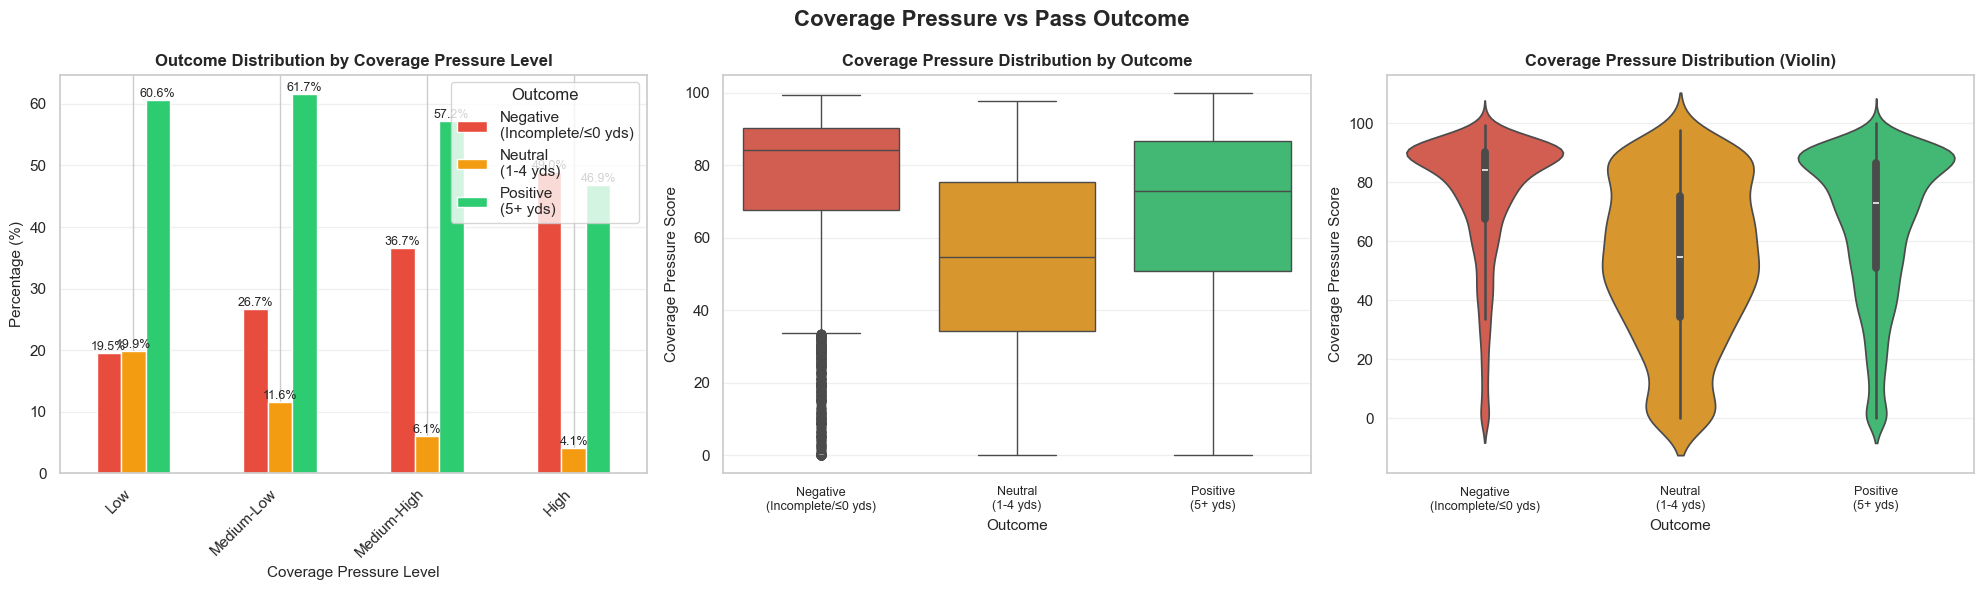


=== Coverage Pressure Analysis ===

Outcome Distribution by Coverage Pressure Level:
y_outcome         0      1      2
coverage_bin                     
Low           19.48  19.88  60.63
Medium-Low    26.75  11.57  61.68
Medium-High   36.66   6.09  57.24
High          49.02   4.12  46.86

Coverage Pressure Statistics by Outcome:
            count    mean     std  min    25%   50%    75%    max
y_outcome                                                        
0          4648.0  74.928  22.273  0.0  67.60  84.1  90.30   99.4
1          1471.0  52.937  26.827  0.0  34.25  54.7  75.25   97.8
2          7986.0  65.818  25.147  0.0  50.80  73.0  86.60  100.0


In [25]:
# Analyze Coverage Pressure vs Outcome
coverage_feature = 'tr_coverage_pressure_score'

# Create bins for coverage pressure (quartiles)
df['coverage_bin'] = pd.qcut(df[coverage_feature], q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'], duplicates='drop')

# Calculate outcome distribution by coverage bin
coverage_outcome_crosstab = pd.crosstab(df['coverage_bin'], df['y_outcome'], normalize='index') * 100

# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Coverage Pressure vs Pass Outcome', fontsize=16, fontweight='bold')

# 1. Grouped Bar Chart - Success Rate by Coverage Bin
coverage_outcome_crosstab.plot(kind='bar', ax=axes[0], color=[outcome_colors_map[i] for i in range(3)])
axes[0].set_title('Outcome Distribution by Coverage Pressure Level', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Coverage Pressure Level', fontsize=11)
axes[0].set_ylabel('Percentage (%)', fontsize=11)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].legend(title='Outcome', labels=[outcome_labels[i] for i in range(3)], loc='upper right')
axes[0].grid(True, alpha=0.3, axis='y')

# Add percentage labels on bars
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.1f%%', fontsize=9)

# 2. Boxplot - Coverage Pressure Distribution by Outcome
df_coverage_plot = df[[coverage_feature, 'y_outcome']].copy()
df_coverage_plot['y_outcome_label'] = df_coverage_plot['y_outcome'].map(outcome_labels)

sns.boxplot(data=df_coverage_plot, x='y_outcome', y=coverage_feature, 
            palette=[outcome_colors_map[i] for i in range(3)], ax=axes[1])
axes[1].set_title('Coverage Pressure Distribution by Outcome', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Outcome', fontsize=11)
axes[1].set_ylabel('Coverage Pressure Score', fontsize=11)
axes[1].set_xticklabels([outcome_labels[i] for i in range(3)], fontsize=9)
axes[1].grid(True, alpha=0.3, axis='y')

# 3. Violin Plot - Coverage Pressure Distribution
sns.violinplot(data=df_coverage_plot, x='y_outcome', y=coverage_feature,
               palette=[outcome_colors_map[i] for i in range(3)], ax=axes[2], inner='box')
axes[2].set_title('Coverage Pressure Distribution (Violin)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Outcome', fontsize=11)
axes[2].set_ylabel('Coverage Pressure Score', fontsize=11)
axes[2].set_xticklabels([outcome_labels[i] for i in range(3)], fontsize=9)
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(FIG_DIR / "coverage_pressure_vs_outcome.png", dpi=300, bbox_inches='tight')

if SHOW_PLOTS:
    plt.show()
else:
    plt.close()

# Print summary statistics
print("\n=== Coverage Pressure Analysis ===")
print("\nOutcome Distribution by Coverage Pressure Level:")
print(coverage_outcome_crosstab.round(2))

print("\nCoverage Pressure Statistics by Outcome:")
print(df.groupby('y_outcome')[coverage_feature].describe().round(3))

## Feature Correlations

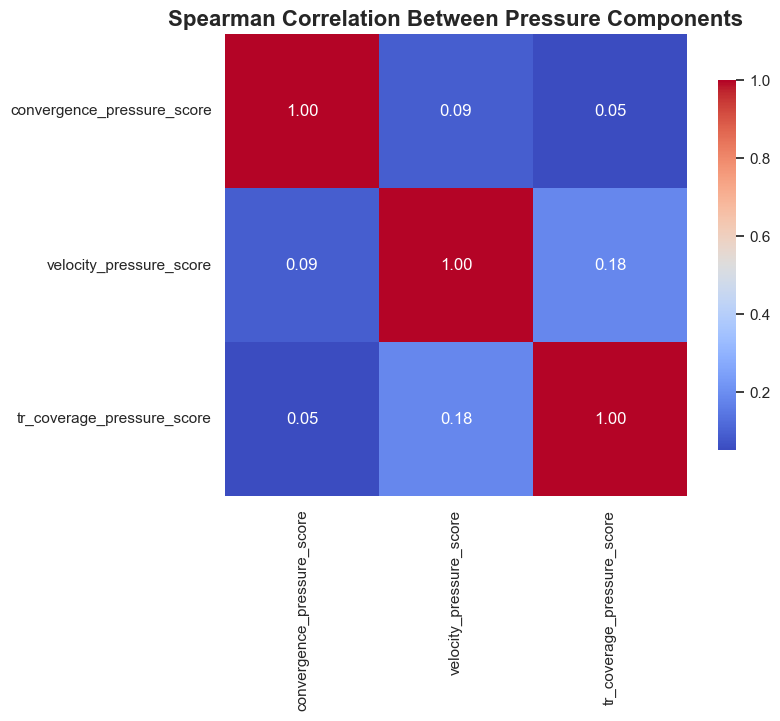

In [26]:
# Feature Interactions. Check correlation and 2d heatmap between features for visualization
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
# Compute correlation matrix
corr = df[pressure_components].corr(method='spearman')
# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title("Spearman Correlation Between Pressure Components", fontsize=16, fontweight='bold')
plt.savefig(FIG_DIR / "feature_correlation_heatmap.png", dpi=300, bbox_inches='tight')
if SHOW_PLOTS:
    plt.show()
else:
    plt.close()


# Baseline Model Evaluation

## Evaluate pressure components (Individual, pairwise, and combined) for predicting y_outcome variables

In [27]:
# Update the evaluation functions to use y_outcome
from itertools import combinations
from sklearn.metrics import classification_report

def cross_val_probs_multiclass(model, X, y, cv):
    """Return cross-validated predicted probabilities for all classes."""
    y_proba = cross_val_predict(model, X, y, cv=cv, method="predict_proba", n_jobs=-1)
    return y_proba

def evaluate_component_3way(df, component_name, cv):
    """Evaluate a single component for 3-way classification."""
    print(f"\n=== Evaluating component: {component_name} (3-way) ===")
    X = df[[component_name]].values.reshape(-1, 1)
    y = df["y_outcome"].values
    print("Count:", len(y))
    print("Class distribution:\n", pd.Series(y).value_counts().sort_index())
    
    # Feature stats
    stats = {
        'mean': np.nanmean(X),
        'std': np.nanstd(X), 
        'min': np.nanmin(X),
        'max': np.nanmax(X)
    }
    print("Feature stats: mean={:.4f}, std={:.4f}, min={:.4f}, max={:.4f}".format(
        stats['mean'], stats['std'], stats['min'], stats['max']
    ))
    
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    # Use multinomial logistic regression
    model = LogisticRegression(multi_class='multinomial', solver='lbfgs', 
                               max_iter=1000, random_state=RANDOM_STATE)
    proba = cross_val_probs_multiclass(model, Xs, y, cv)
    
    # Calculate one-vs-rest ROC AUC for each class
    from sklearn.metrics import roc_auc_score
    from sklearn.preprocessing import label_binarize
    
    y_bin = label_binarize(y, classes=[0, 1, 2])
    roc_auc_ovr = roc_auc_score(y_bin, proba, average='weighted', multi_class='ovr')
    roc_auc_ovo = roc_auc_score(y, proba, average='weighted', multi_class='ovo')
    
    print(f"CV ROC AUC (OvR): {roc_auc_ovr:.4f}")
    print(f"CV ROC AUC (OvO): {roc_auc_ovo:.4f}")
    
    # Get predictions and confusion matrix
    y_pred = np.argmax(proba, axis=1)
    cm = confusion_matrix(y, y_pred)
    print("Confusion matrix:\n", cm)
    
    # Calculate per-class metrics
    from sklearn.metrics import classification_report
    print("\nClassification Report:")
    print(classification_report(y, y_pred, 
                                target_names=['Negative', 'Neutral', 'Positive'],
                                digits=3))

    return {
        "component": component_name,
        "roc_auc_ovr": roc_auc_ovr,
        "roc_auc_ovo": roc_auc_ovo,
        "stats": stats,
        "confusion_matrix": cm,
        "plot_data": {
            "probabilities": proba,
            "y_true": y,
            "y_pred": y_pred
        }
    }

def evaluate_combined_3way(df, features, cv):
    """Evaluate combined models for 3-way classification."""
    print("\n=== Evaluating combined model (3-way) ===")
    X = df[features].values
    y = df["y_outcome"].values
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    log = LogisticRegression(multi_class='multinomial', solver='lbfgs', 
                            max_iter=1000, random_state=RANDOM_STATE)
    rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)

    proba_log = cross_val_probs_multiclass(log, Xs, y, cv)
    proba_rf = cross_val_probs_multiclass(rf, Xs, y, cv)
    
    from sklearn.preprocessing import label_binarize
    y_bin = label_binarize(y, classes=[0, 1, 2])

    results = {}
    for name, proba in [("Logistic", proba_log), ("RandomForest", proba_rf)]:
        roc_auc_ovr = roc_auc_score(y_bin, proba, average='weighted', multi_class='ovr')
        roc_auc_ovo = roc_auc_score(y, proba, average='weighted', multi_class='ovo')
        
        y_pred = np.argmax(proba, axis=1)
        cm = confusion_matrix(y, y_pred)
        
        print(f"\n{name}:")
        print(f"  ROC AUC (OvR): {roc_auc_ovr:.4f}")
        print(f"  ROC AUC (OvO): {roc_auc_ovo:.4f}")
        print(f"  Confusion Matrix:\n{cm}")
        print(f"\n  Classification Report:")
        print(classification_report(y, y_pred, 
                                   target_names=['Negative', 'Neutral', 'Positive'],
                                   digits=3))
        
        results[name.lower()] = {
            "roc_auc_ovr": roc_auc_ovr,
            "roc_auc_ovo": roc_auc_ovo,
            "confusion_matrix": cm,
            "probabilities": proba,
            "y_pred": y_pred
        }

    # Permutation importance
    rf.fit(Xs, y)
    perm = permutation_importance(rf, Xs, y, n_repeats=20, random_state=RANDOM_STATE, n_jobs=-1)
    importances = pd.Series(perm.importances_mean, index=features).sort_values(ascending=False)
    print("\nPermutation importances (combined RF):")
    print(importances.round(4))

    return {
        "results": results,
        "importances": importances,
        "y_true": y
    }

def evaluate_component_pairs_3way(df, components, cv):
    """Evaluate pairwise combinations for 3-way classification."""
    print("\n=== Evaluating pairwise combinations (3-way) ===")
    
    component_pairs = list(combinations(components, 2))
    pair_results = {}
    
    from sklearn.preprocessing import label_binarize
    
    for pair in component_pairs:
        pair_name = f"{pair[0]} + {pair[1]}"
        print(f"\n--- Evaluating pair: {pair_name} ---")
        
        X = df[list(pair)].values
        y = df["y_outcome"].values
        y_bin = label_binarize(y, classes=[0, 1, 2])
        
        scaler = StandardScaler()
        Xs = scaler.fit_transform(X)

        log = LogisticRegression(multi_class='multinomial', solver='lbfgs', 
                                max_iter=1000, random_state=RANDOM_STATE)
        rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)

        proba_log = cross_val_probs_multiclass(log, Xs, y, cv)
        proba_rf = cross_val_probs_multiclass(rf, Xs, y, cv)

        pair_results[pair_name] = {}
        
        for model_name, proba in [("Logistic", proba_log), ("RandomForest", proba_rf)]:
            roc_auc_ovr = roc_auc_score(y_bin, proba, average='weighted', multi_class='ovr')
            roc_auc_ovo = roc_auc_score(y, proba, average='weighted', multi_class='ovo')
            
            y_pred = np.argmax(proba, axis=1)
            cm = confusion_matrix(y, y_pred)
            
            print(f"{model_name} CV ROC AUC (OvR): {roc_auc_ovr:.4f}, (OvO): {roc_auc_ovo:.4f}")
            
            pair_results[pair_name][model_name.lower()] = {
                "roc_auc_ovr": roc_auc_ovr,
                "roc_auc_ovo": roc_auc_ovo,
                "confusion_matrix": cm,
                "probabilities": proba,
                "y_pred": y_pred,
                "features": list(pair)
            }

        # Permutation importance
        rf_full = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
        rf_full.fit(Xs, y)
        perm = permutation_importance(rf_full, Xs, y, n_repeats=20, random_state=RANDOM_STATE, n_jobs=-1)
        importances = pd.Series(perm.importances_mean, index=pair).sort_values(ascending=False)
        print(f"Permutation importances:")
        print(importances.round(4))
        
        pair_results[pair_name]["importances"] = importances
        pair_results[pair_name]["y_true"] = y
    
    return pair_results

# Update main function for 3-way classification
def main_3way():
    if not DATA_PATH.exists():
        current_dir = Path.cwd()
        abs_path = DATA_PATH.resolve()
        print(f"ERROR: Data file not found!")
        print(f"Current working directory: {current_dir}")
        print(f"Looking for file at: {abs_path}")
        return None, None, None, None
    
    df = load_and_prepare(DATA_PATH)
    print("Loaded data shape:", df.shape)
    print("y_outcome counts:\n", df["y_outcome"].value_counts().sort_index())
    
    cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    
    # Evaluate individual components
    component_results = []
    for comp in pressure_components:
        res = evaluate_component_3way(df, comp, cv)
        component_results.append(res)
    
    # Evaluate pairwise combinations
    pair_results = evaluate_component_pairs_3way(df, pressure_components, cv)
    
    # Evaluate combined models
    combined_results = evaluate_combined_3way(df, pressure_components, cv)
    
    # Create summary
    summary_data = []
    
    for result in component_results:
        summary_data.append({
            'Type': 'Individual',
            'Features': result['component'],
            'Model': 'Logistic',
            'ROC_AUC_OvR': result['roc_auc_ovr'],
            'ROC_AUC_OvO': result['roc_auc_ovo']
        })
    
    for pair_name, results in pair_results.items():
        for model_name in ['logistic', 'randomforest']:
            if model_name in results:
                summary_data.append({
                    'Type': 'Pairwise',
                    'Features': pair_name,
                    'Model': model_name.title(),
                    'ROC_AUC_OvR': results[model_name]['roc_auc_ovr'],
                    'ROC_AUC_OvO': results[model_name]['roc_auc_ovo']
                })
    
    for model_name, results in combined_results['results'].items():
        summary_data.append({
            'Type': 'Combined_All',
            'Features': 'All 3 Components',
            'Model': model_name.title(),
            'ROC_AUC_OvR': results['roc_auc_ovr'],
            'ROC_AUC_OvO': results['roc_auc_ovo']
        })
    
    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.sort_values('ROC_AUC_OvR', ascending=False)
    
    print("\n=== 3-WAY CLASSIFICATION PERFORMANCE SUMMARY ===")
    # Format numeric columns to 4 decimal places
    summary_display = summary_df.copy()
    summary_display['ROC_AUC_OvR'] = summary_display['ROC_AUC_OvR'].map('{:.4f}'.format)
    summary_display['ROC_AUC_OvO'] = summary_display['ROC_AUC_OvO'].map('{:.4f}'.format)
    print(summary_display.to_string(index=False))
    
    return component_results, pair_results, combined_results, summary_df

# Run the 3-way analysis
component_res_3way, pair_res_3way, combined_res_3way, summary_df_3way = main_3way()


3-Way Outcome Distribution:
y_outcome
0    4648
1    1471
2    7986
Name: count, dtype: int64
  0 (Negative Play): 4648 plays - Incomplete or ≤0 yards
  1 (Neutral Play):  1471 plays - Complete with 1-4 yards
  2 (Positive Play): 7986 plays - Complete with 5+ yards

Binary Classification (y_incomplete) Distribution:
  0 (Complete): 9737 plays
  1 (Incomplete/Intercepted): 4368 plays

Route Type Distribution:
route_type
DEEP            2675
INTERMEDIATE    5359
SHORT           6069
Name: count, dtype: int64

Missing route_type values: 2
Loaded data shape: (14105, 46)
y_outcome counts:
 y_outcome
0    4648
1    1471
2    7986
Name: count, dtype: int64

=== Evaluating component: convergence_pressure_score (3-way) ===
Count: 14105
Class distribution:
 0    4648
1    1471
2    7986
Name: count, dtype: int64
Feature stats: mean=13.4404, std=25.3473, min=0.0000, max=100.0000
CV ROC AUC (OvR): 0.4957
CV ROC AUC (OvO): 0.4954
Confusion matrix:
 [[   0    0 4648]
 [   0    0 1471]
 [   0    0 7

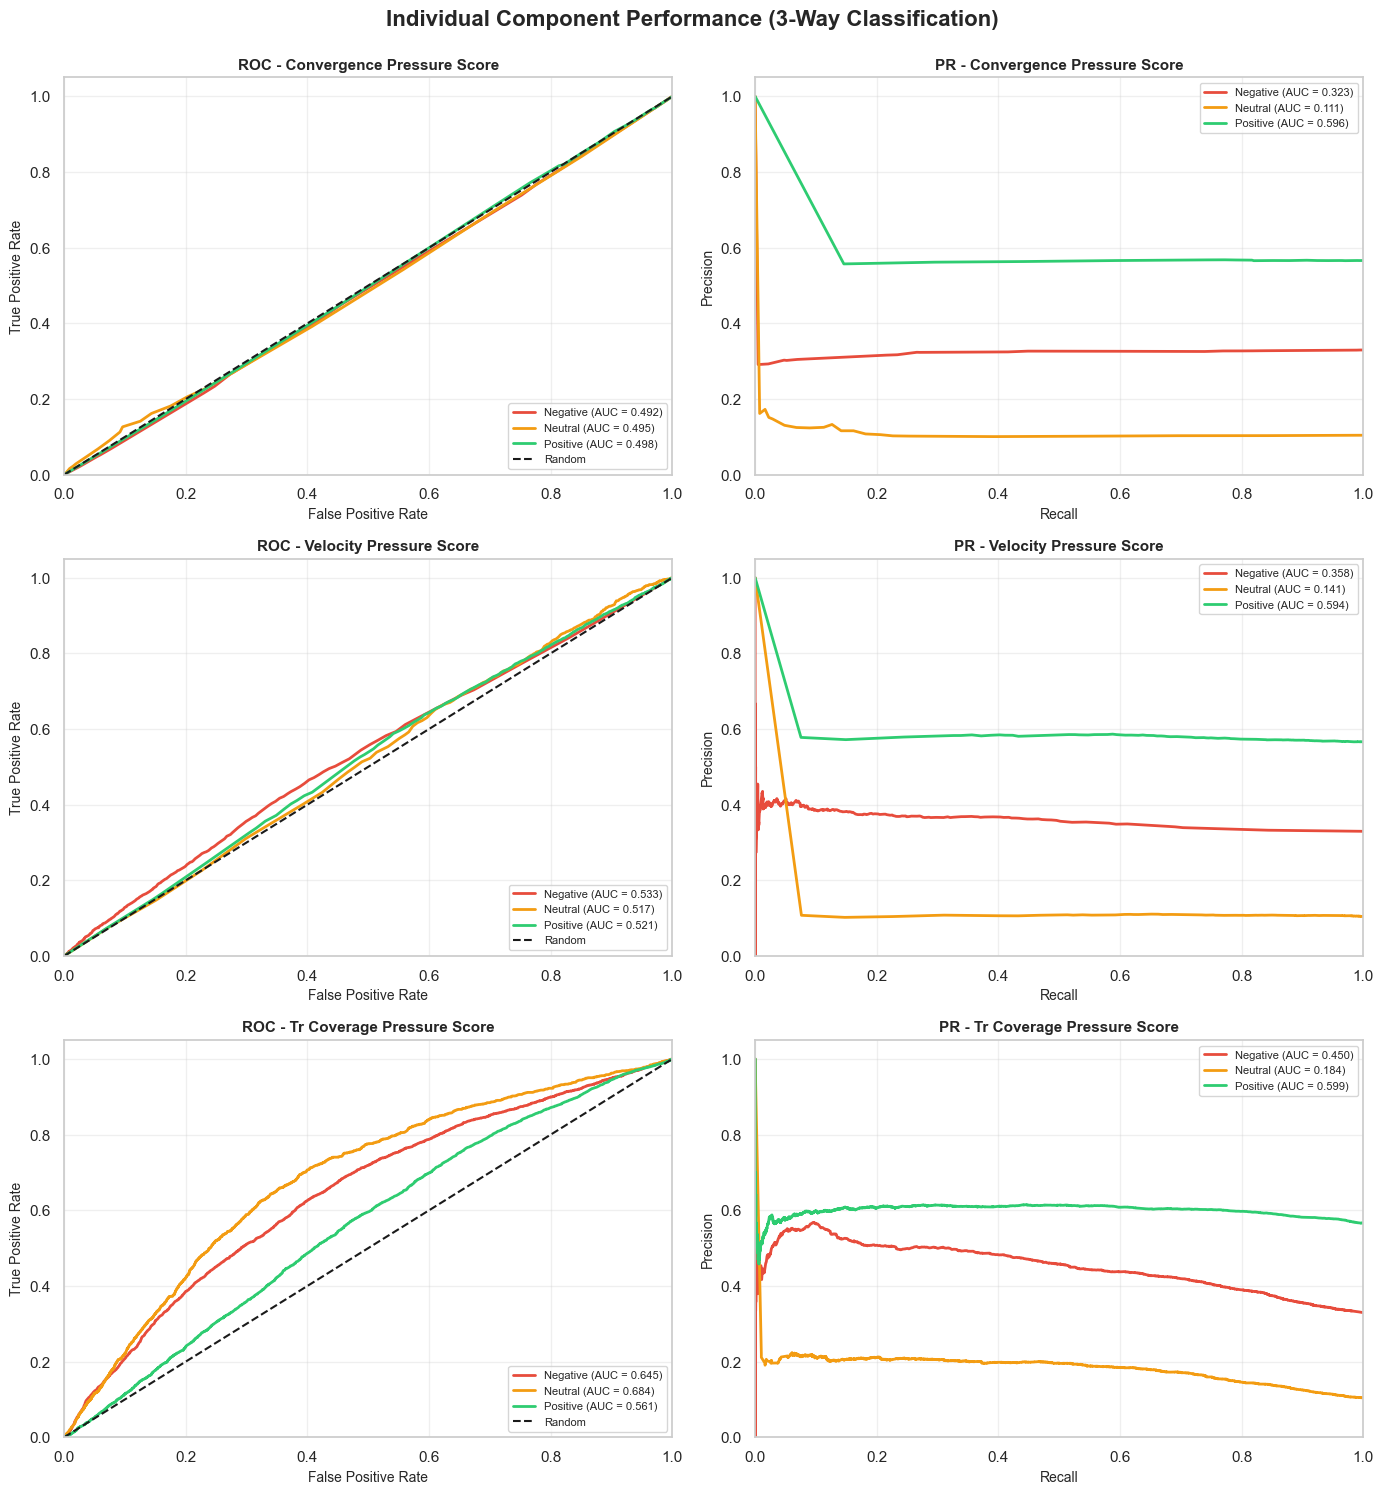

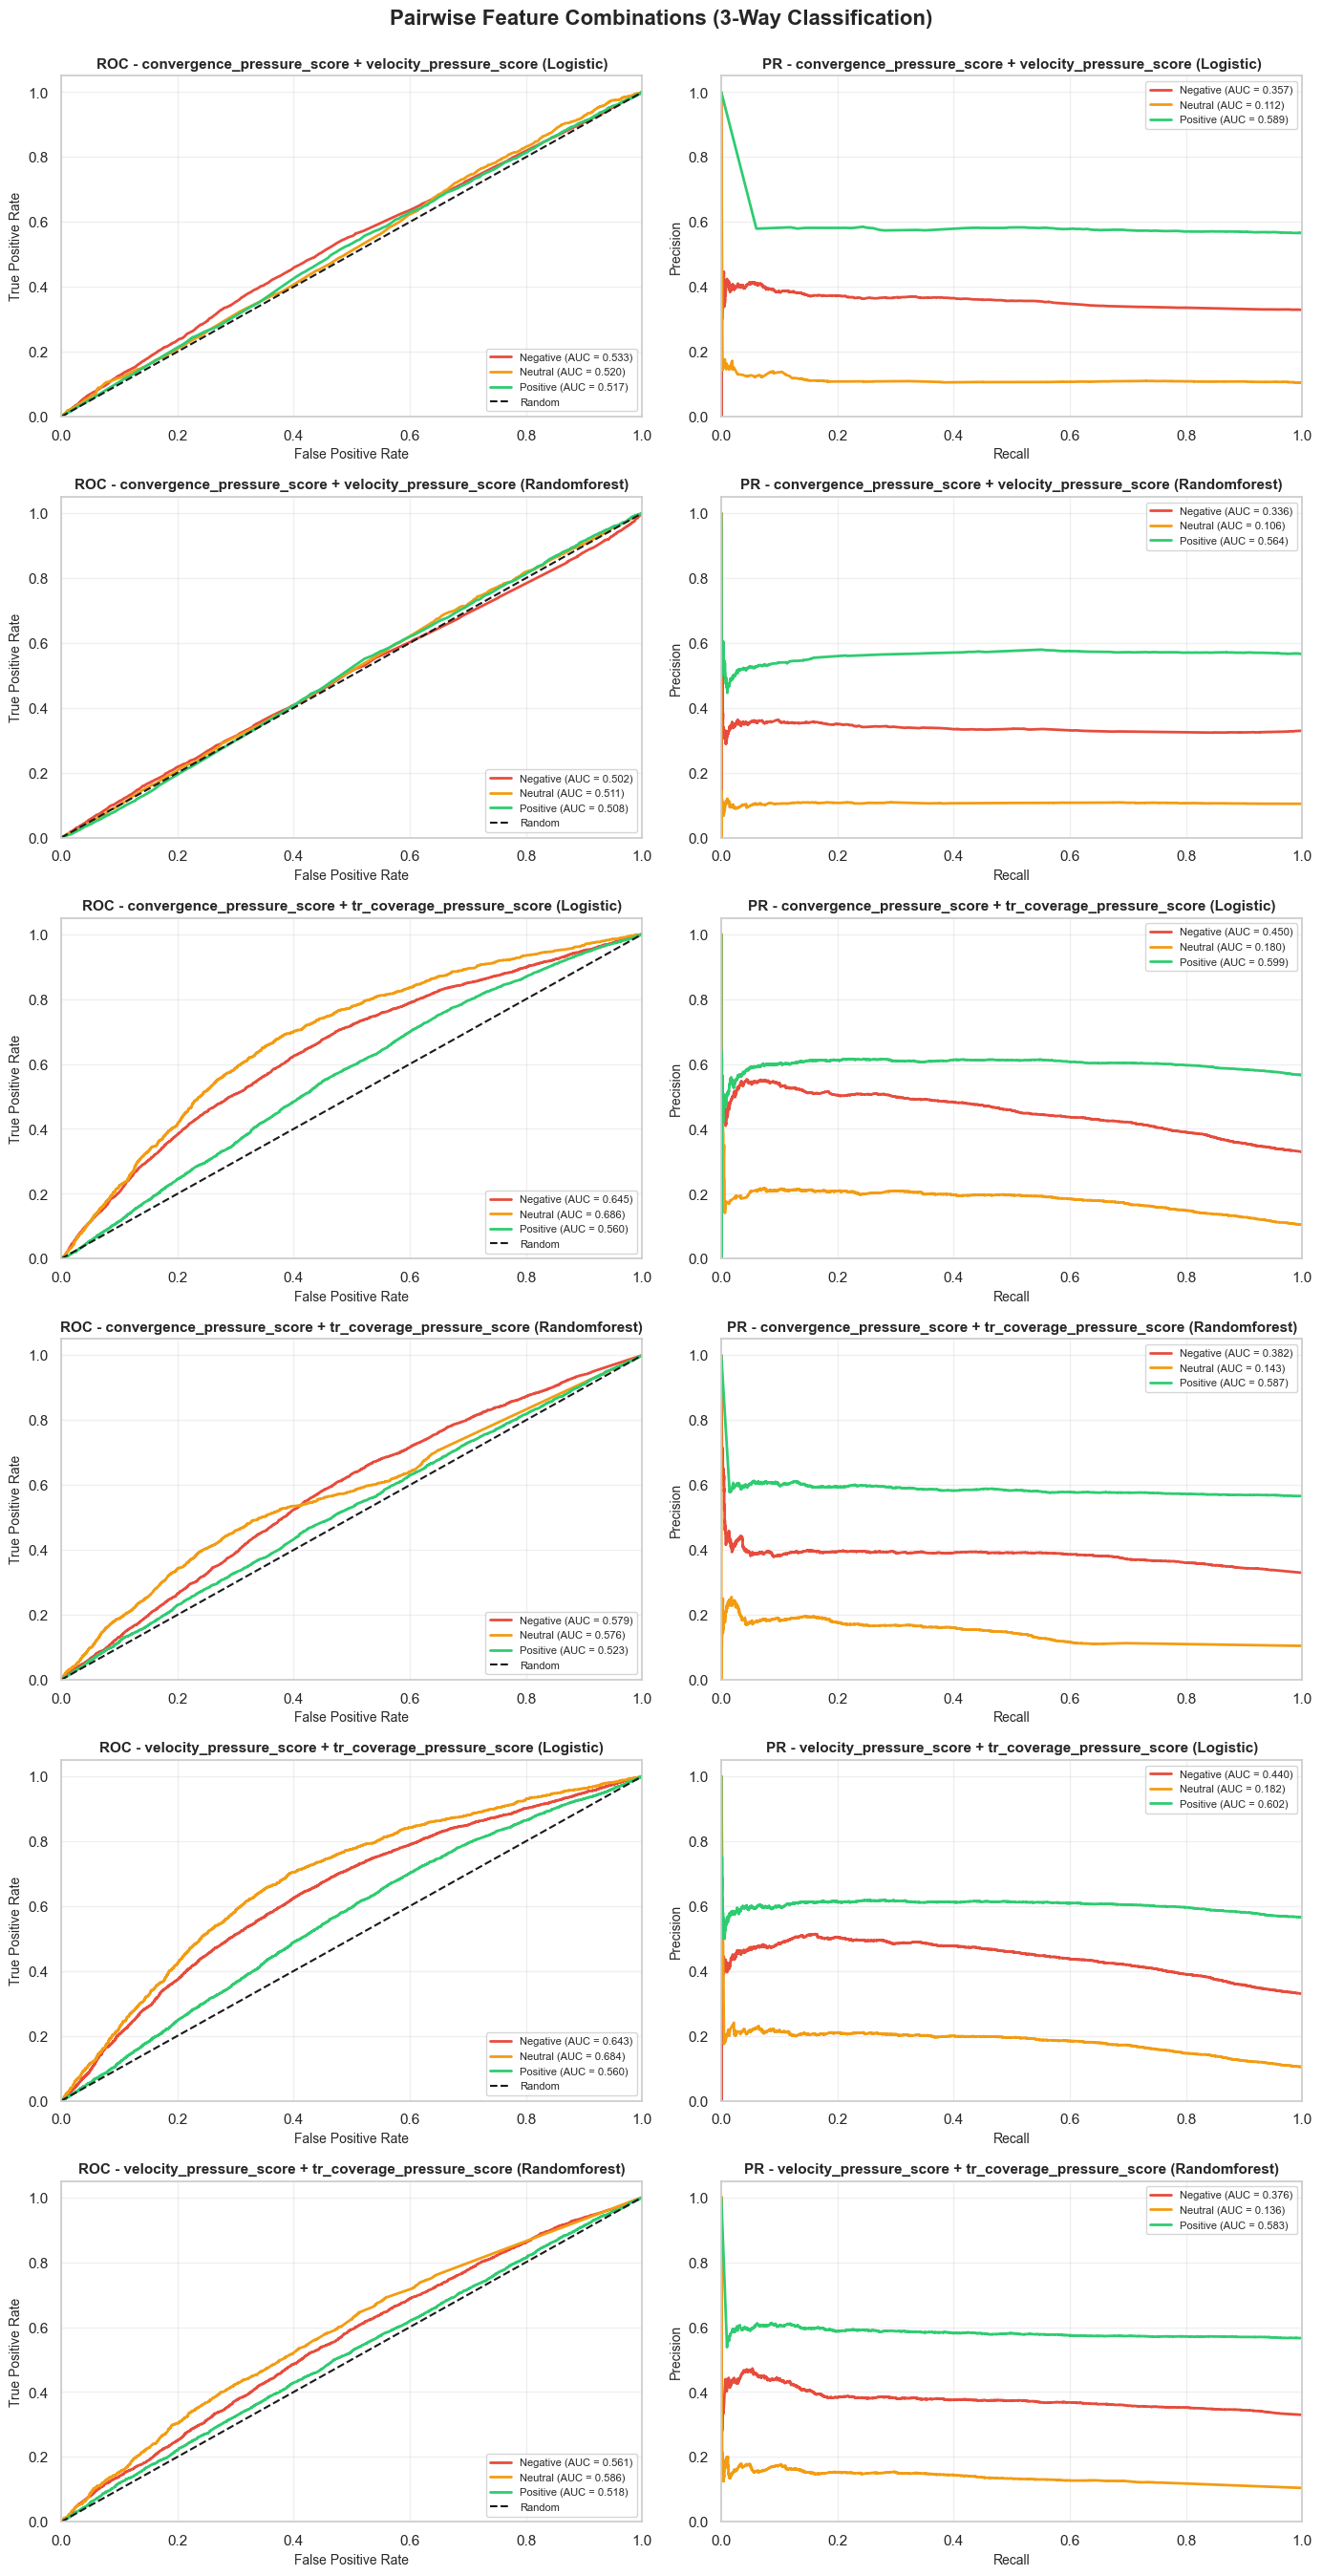

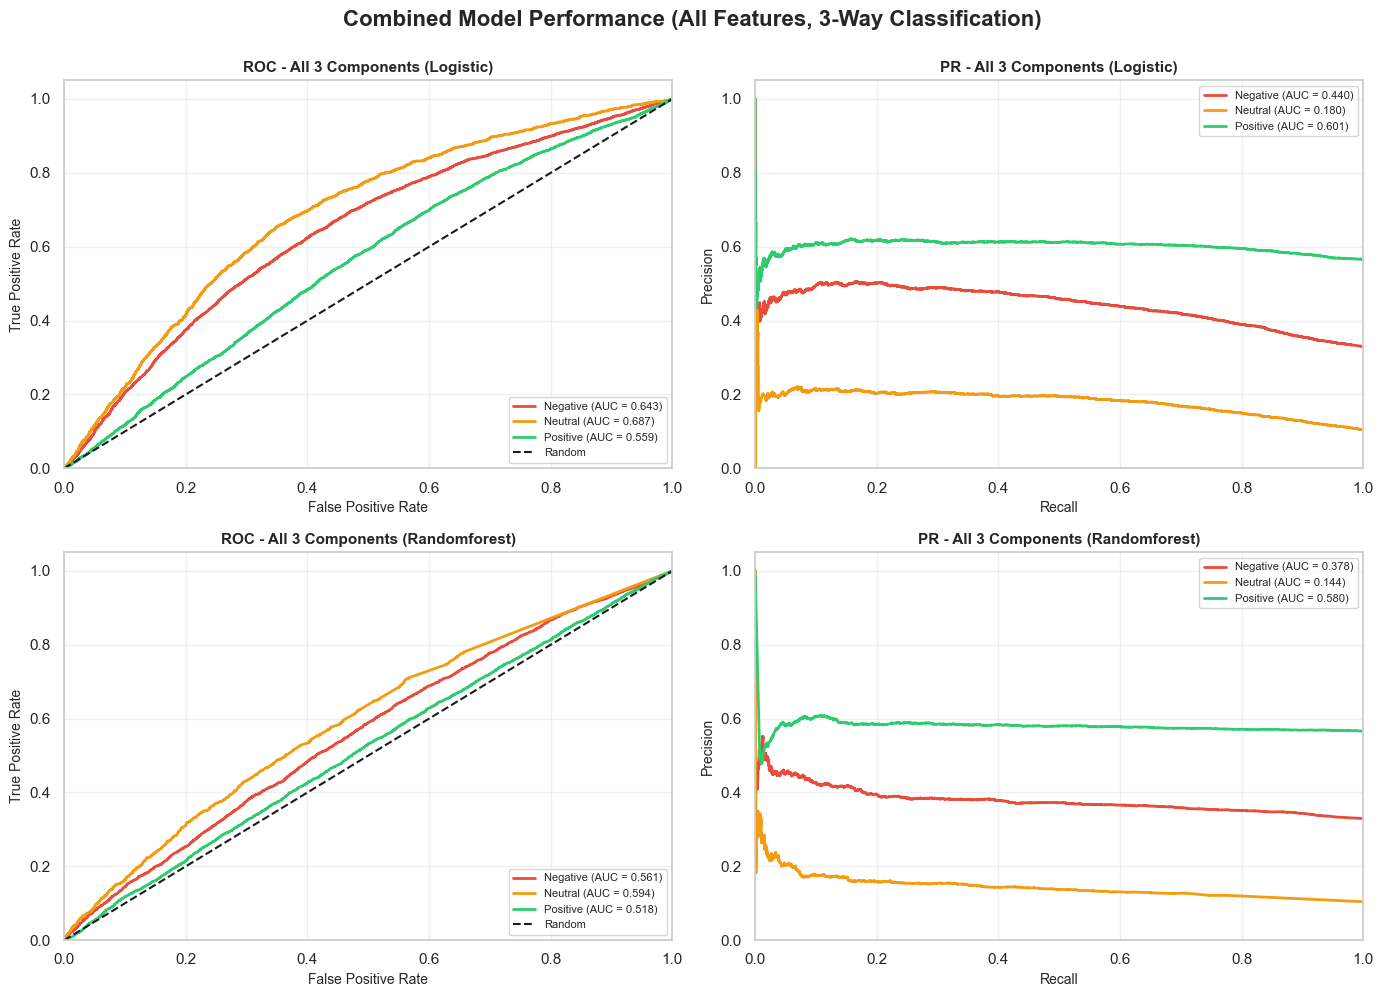


✓ Clustered ROC/PR plots saved:
  • figures\cluster_01_individual_components.png
  • figures\cluster_02_pairwise_combinations.png
  • figures\cluster_03_combined_models.png


In [28]:
def plot_multiclass_roc_pr_curves(component_results, pair_results, combined_results, output_dir):
    """
    Plot ROC and PR curves for multi-class classification with clustered subplots.
    Creates 3 summary figures: Individual, Pairwise, and Combined models.
    """
    from sklearn.preprocessing import label_binarize
    from sklearn.metrics import roc_curve, auc, precision_recall_curve
    
    class_names = ['Negative', 'Neutral', 'Positive']
    colors = ['#e74c3c', '#f39c12', '#2ecc71']
    
    def plot_single_model_curves(ax_roc, ax_pr, y_true, y_proba, title):
        """Helper to plot ROC and PR curves on given axes."""
        y_bin = label_binarize(y_true, classes=[0, 1, 2])
        
        # ROC Curve
        for i, (class_name, color) in enumerate(zip(class_names, colors)):
            fpr, tpr, _ = roc_curve(y_bin[:, i], y_proba[:, i])
            roc_auc = auc(fpr, tpr)
            ax_roc.plot(fpr, tpr, color=color, lw=2, 
                       label=f'{class_name} (AUC = {roc_auc:.3f})')
        
        ax_roc.plot([0, 1], [0, 1], 'k--', lw=1.5, label='Random')
        ax_roc.set_xlim([0.0, 1.0])
        ax_roc.set_ylim([0.0, 1.05])
        ax_roc.set_xlabel('False Positive Rate', fontsize=10)
        ax_roc.set_ylabel('True Positive Rate', fontsize=10)
        ax_roc.set_title(f'ROC - {title}', fontsize=11, fontweight='bold')
        ax_roc.legend(loc='lower right', fontsize=8)
        ax_roc.grid(True, alpha=0.3)
        
        # PR Curve
        for i, (class_name, color) in enumerate(zip(class_names, colors)):
            precision, recall, _ = precision_recall_curve(y_bin[:, i], y_proba[:, i])
            pr_auc = auc(recall, precision)
            ax_pr.plot(recall, precision, color=color, lw=2,
                      label=f'{class_name} (AUC = {pr_auc:.3f})')
        
        ax_pr.set_xlim([0.0, 1.0])
        ax_pr.set_ylim([0.0, 1.05])
        ax_pr.set_xlabel('Recall', fontsize=10)
        ax_pr.set_ylabel('Precision', fontsize=10)
        ax_pr.set_title(f'PR - {title}', fontsize=11, fontweight='bold')
        ax_pr.legend(loc='best', fontsize=8)
        ax_pr.grid(True, alpha=0.3)
    
    # =========================================================================
    # CLUSTER 1: INDIVIDUAL COMPONENTS (3 rows x 2 cols)
    # =========================================================================
    n_individual = len(component_results)
    fig, axes = plt.subplots(n_individual, 2, figsize=(14, 5*n_individual))
    fig.suptitle('Individual Component Performance (3-Way Classification)', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    for idx, result in enumerate(component_results):
        ax_roc = axes[idx, 0] if n_individual > 1 else axes[0]
        ax_pr = axes[idx, 1] if n_individual > 1 else axes[1]
        
        plot_single_model_curves(
            ax_roc, ax_pr,
            y_true=result['plot_data']['y_true'],
            y_proba=result['plot_data']['probabilities'],
            title=result["component"].replace('_', ' ').title()
        )
    
    plt.tight_layout()
    plt.savefig(output_dir / "cluster_01_individual_components.png", dpi=300, bbox_inches='tight')
    plt.show() if SHOW_PLOTS else plt.close()
    
    # =========================================================================
    # CLUSTER 2: PAIRWISE COMBINATIONS (N pairs x 2 models = 2N rows x 2 cols)
    # =========================================================================
    pair_plot_specs = []
    for pair_name, pair_data in pair_results.items():
        for model_name in ['logistic', 'randomforest']:
            pair_plot_specs.append({
                'y_true': pair_data['y_true'],
                'y_proba': pair_data[model_name]['probabilities'],
                'title': f"{pair_name} ({model_name.title()})"
            })
    
    n_pairs = len(pair_plot_specs)
    fig, axes = plt.subplots(n_pairs, 2, figsize=(14, 4.5*n_pairs))
    fig.suptitle('Pairwise Feature Combinations (3-Way Classification)', 
                 fontsize=16, fontweight='bold', y=0.998)
    
    for idx, spec in enumerate(pair_plot_specs):
        ax_roc = axes[idx, 0] if n_pairs > 1 else axes[0]
        ax_pr = axes[idx, 1] if n_pairs > 1 else axes[1]
        
        plot_single_model_curves(ax_roc, ax_pr, **spec)
    
    plt.tight_layout()
    plt.savefig(output_dir / "cluster_02_pairwise_combinations.png", dpi=300, bbox_inches='tight')
    plt.show() if SHOW_PLOTS else plt.close()
    
    # =========================================================================
    # CLUSTER 3: COMBINED MODELS (2 models x 2 cols)
    # =========================================================================
    combined_plot_specs = []
    for model_name, model_data in combined_results['results'].items():
        combined_plot_specs.append({
            'y_true': combined_results['y_true'],
            'y_proba': model_data['probabilities'],
            'title': f'All 3 Components ({model_name.title()})'
        })
    
    n_combined = len(combined_plot_specs)
    fig, axes = plt.subplots(n_combined, 2, figsize=(14, 5*n_combined))
    fig.suptitle('Combined Model Performance (All Features, 3-Way Classification)', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    for idx, spec in enumerate(combined_plot_specs):
        ax_roc = axes[idx, 0] if n_combined > 1 else axes[0]
        ax_pr = axes[idx, 1] if n_combined > 1 else axes[1]
        
        plot_single_model_curves(ax_roc, ax_pr, **spec)
    
    plt.tight_layout()
    plt.savefig(output_dir / "cluster_03_combined_models.png", dpi=300, bbox_inches='tight')
    plt.show() if SHOW_PLOTS else plt.close()
    
    print(f"\n✓ Clustered ROC/PR plots saved:")
    print(f"  • {output_dir / 'cluster_01_individual_components.png'}")
    print(f"  • {output_dir / 'cluster_02_pairwise_combinations.png'}")
    print(f"  • {output_dir / 'cluster_03_combined_models.png'}")

# Generate clustered plots
plot_multiclass_roc_pr_curves(component_res_3way, pair_res_3way, combined_res_3way, FIG_DIR)

# Evaluate each component with Route

In [29]:
# Analyze categorical features vs outcome
# list the catagories in column 'route_type' and route_of_targeted_receiver
df['route_type'].unique()
# Get 2-way frequency table of 'route_type' vs 'y_outcome'
freq_table = pd.crosstab(df['route_type'], df['y_outcome'])
print("\nFrequency table of 'route_type' vs 'y_outcome':")
print(freq_table)


# list the catagories in column 'route_of_targeted_receiver'    
df['route_of_targeted_receiver'].unique()
# Get 2-way frequency table of 'route_of_targeted_receiver' vs 'y_outcome'
freq_table_targeted = pd.crosstab(df['route_of_targeted_receiver'], df['y_outcome'])
print("\nFrequency table of 'route_of_targeted_receiver' vs 'y_outcome':")
print(freq_table_targeted)

                                                                       



Frequency table of 'route_type' vs 'y_outcome':
y_outcome        0    1     2
route_type                   
DEEP          1412   29  1234
INTERMEDIATE  1695  548  3116
SHORT         1540  893  3636

Frequency table of 'route_of_targeted_receiver' vs 'y_outcome':
y_outcome                     0    1     2
route_of_targeted_receiver                
ANGLE                        98  102   343
CORNER                      250   12   247
CROSS                       474  167   855
FLAT                        477  553   953
GO                          816   10   571
HITCH                       641  216  1803
IN                          442   46   618
OUT                         681  233  1300
POST                        346    7   416
SCREEN                       78   77   146
SLANT                       304   47   698
WHEEL                        40    0    36


## Descriptive Statistics and Visualizations by Route Type
Sample Size and Distribution Analysis
Route Type Distribution Visualization
Outcome Distribution by Route Type
Outcome Visualization - Grouped Bar Charts
Outcome Visualization - Stacked Proportions
Yards Gained Analysis - Complete Passes Only
Yards Gained Visualization by Route Type
Risk-Reward Profile Summary

ROUTE TYPE DESCRIPTIVE ANALYSIS

1A. SAMPLE SIZE & DISTRIBUTION

Overall Route Type Distribution:
  Route Type  Total Plays (n)  % of Dataset
        DEEP             2675         18.97
INTERMEDIATE             5359         38.00
       SHORT             6069         43.03

Individual Routes within Each Group:
  route_type route_of_targeted_receiver  Count  % within Group
        DEEP                         GO   1397           52.22
        DEEP                       POST    769           28.75
        DEEP                     CORNER    509           19.03
INTERMEDIATE                        OUT   2214           41.31
INTERMEDIATE                      CROSS   1496           27.92
INTERMEDIATE                         IN   1106           20.64
INTERMEDIATE                      ANGLE    543           10.13
       SHORT                      HITCH   2660           43.83
       SHORT                       FLAT   1983           32.67
       SHORT                      SLANT   1049           1

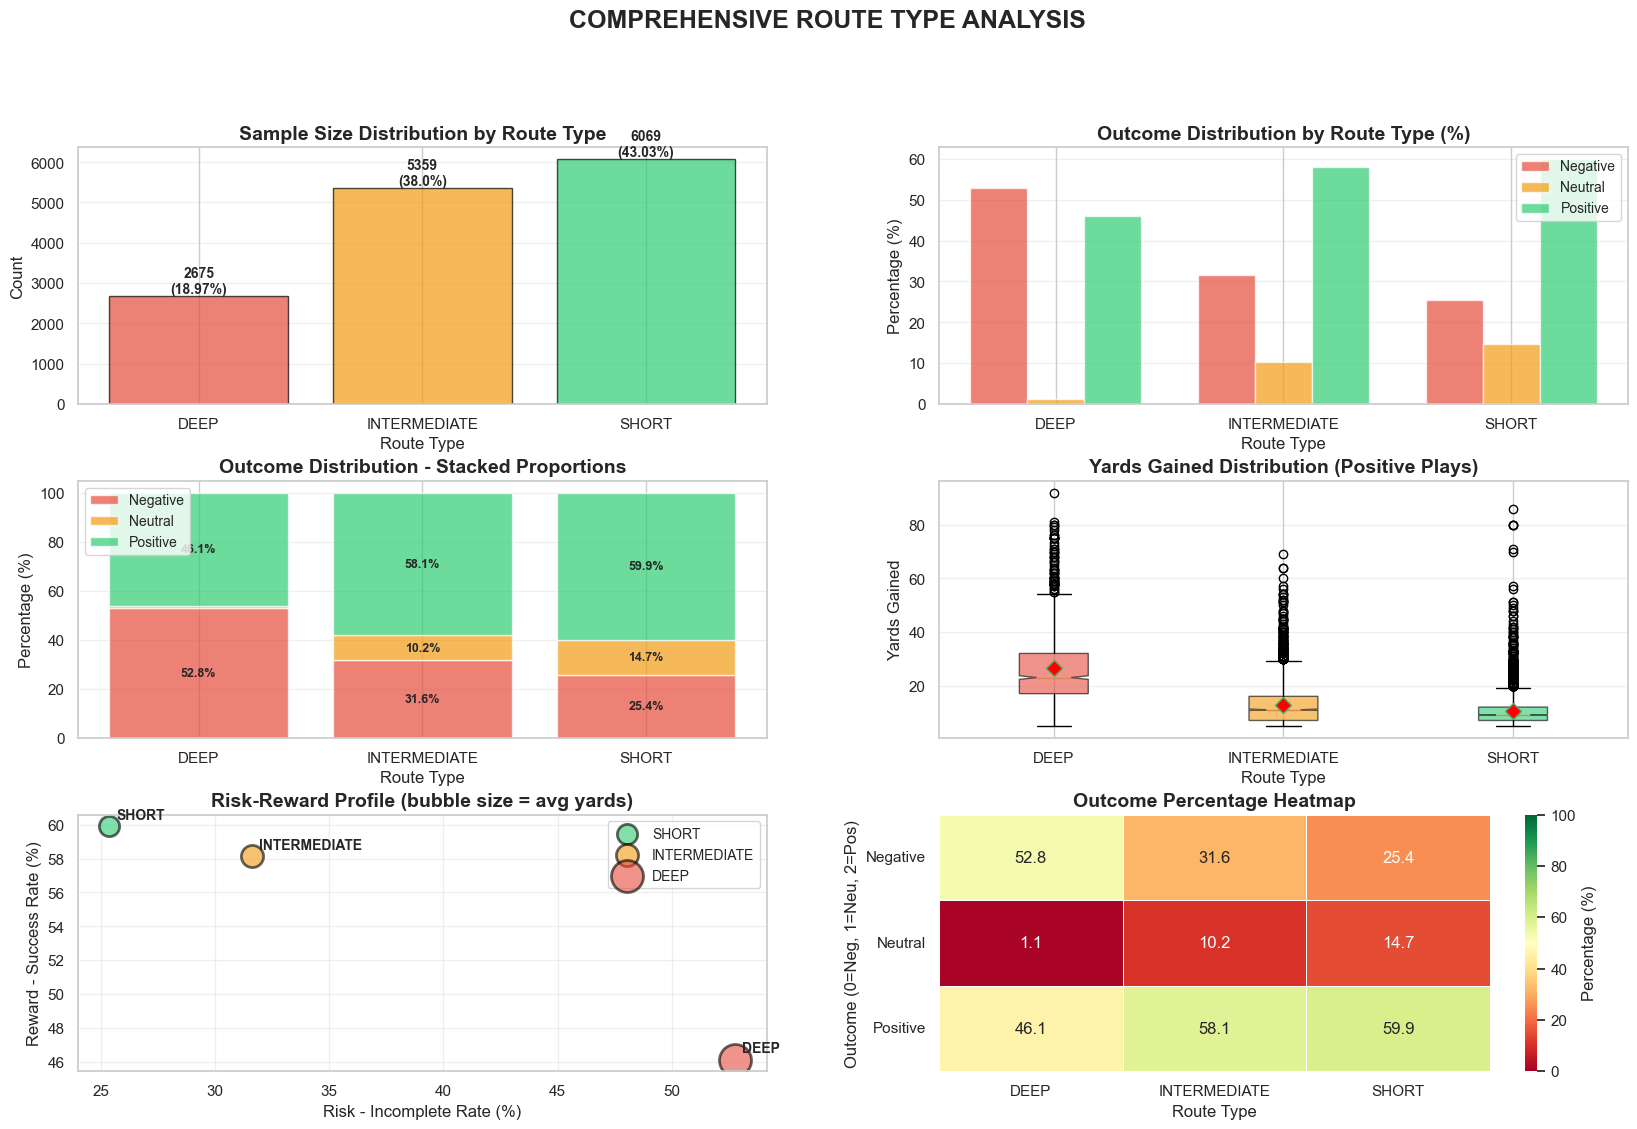


✓ Comprehensive visualization saved: figures\route_type_comprehensive_analysis.png


In [30]:
# ============================================================================
# COMPREHENSIVE ROUTE TYPE DESCRIPTIVE ANALYSIS
# ============================================================================

# Filter out missing route_type values
df_route = df[df['route_type'].notna()].copy()

print("="*100)
print("ROUTE TYPE DESCRIPTIVE ANALYSIS")
print("="*100)

# ----------------------------------------------------------------------------
# 1A. SAMPLE SIZE & DISTRIBUTION ANALYSIS
# ----------------------------------------------------------------------------
print("\n" + "="*100)
print("1A. SAMPLE SIZE & DISTRIBUTION")
print("="*100)

# Calculate counts and percentages using vectorized operations
route_counts = df_route['route_type'].value_counts().sort_index()
route_pcts = (route_counts / len(df_route) * 100).round(2)

# Create summary dataframe
sample_size_summary = pd.DataFrame({
    'Route Type': route_counts.index,
    'Total Plays (n)': route_counts.values,
    '% of Dataset': route_pcts.values
})

print("\nOverall Route Type Distribution:")
print(sample_size_summary.to_string(index=False))

# Individual routes within each group
print("\nIndividual Routes within Each Group:")
route_detail = df_route.groupby(['route_type', 'route_of_targeted_receiver']).size().reset_index(name='Count')
route_detail['% within Group'] = route_detail.groupby('route_type')['Count'].transform(lambda x: (x / x.sum() * 100).round(2))
route_detail = route_detail.sort_values(['route_type', 'Count'], ascending=[True, False])
print(route_detail.to_string(index=False))
# Save sample size summary to CSV
sample_size_summary.to_csv(FIG_DIR / "route_type_sample_size_distribution.csv", index=False)
print(f"\n✓ Sample size summary saved to: {FIG_DIR / 'route_type_sample_size_distribution.csv'}")

# ----------------------------------------------------------------------------
# 1B. OUTCOME DISTRIBUTION BY ROUTE TYPE
# ----------------------------------------------------------------------------
print("\n" + "="*100)
print("1B. OUTCOME DISTRIBUTION BY ROUTE TYPE")
print("="*100)

# Vectorized crosstab calculation
outcome_by_route = pd.crosstab(df_route['route_type'], df_route['y_outcome'], margins=True)
outcome_pct_by_route = pd.crosstab(df_route['route_type'], df_route['y_outcome'], normalize='index') * 100

# Create comprehensive outcome summary
outcome_summary = pd.DataFrame({
    'Route Type': outcome_by_route.index[:-1],  # Exclude 'All' row
    'Negative (n)': outcome_by_route[0].values[:-1],
    'Negative (%)': outcome_pct_by_route[0].round(2).values,
    'Neutral (n)': outcome_by_route[1].values[:-1],
    'Neutral (%)': outcome_pct_by_route[1].round(2).values,
    'Positive (n)': outcome_by_route[2].values[:-1],
    'Positive (%)': outcome_pct_by_route[2].round(2).values,
    'Total': outcome_by_route['All'].values[:-1]
})

print("\nOutcome Distribution (Counts and Percentages):")
print(outcome_summary.to_string(index=False))

# Key insight: Neutral % variation
print("\n📊 KEY INSIGHT - Neutral Play Percentage by Route Type:")
neutral_pcts = outcome_pct_by_route[1].sort_values(ascending=False)
for route, pct in neutral_pcts.items():
    print(f"  {route:15s}: {pct:5.2f}% (Expected: HIGH for SHORT, LOW for DEEP)")

# Save outcome summary to CSV
outcome_summary.to_csv(FIG_DIR / "route_type_outcome_distribution.csv", index=False)
print(f"\n✓ Outcome distribution summary saved to: {FIG_DIR / 'route_type_outcome_distribution.csv'}")

# ----------------------------------------------------------------------------
# 1C. YARDS GAINED ANALYSIS (COMPLETE PASSES ONLY)
# ----------------------------------------------------------------------------
print("\n" + "="*100)
print("1C. YARDS GAINED ANALYSIS - COMPLETE PASSES ONLY")
print("="*100)

# Filter for complete passes (Positive outcomes: y_outcome == 2)
df_complete_positive = df_route[df_route['y_outcome'] == 2].copy()

# Vectorized yards gained statistics
yards_stats = df_complete_positive.groupby('route_type')['yards_gained'].agg([
    ('Count', 'count'),
    ('Mean', lambda x: x.mean().round(2)),
    ('Median', 'median'),
    ('Std', lambda x: x.std().round(2)),
    ('Min', 'min'),
    ('25%', lambda x: x.quantile(0.25)),
    ('75%', lambda x: x.quantile(0.75)),
    ('Max', 'max')
]).reset_index()

print("\nYards Gained Statistics (Positive Plays - 5+ yards):")
print(yards_stats.to_string(index=False))
# Save yards stats to CSV
yards_stats.to_csv(FIG_DIR / "route_type_yards_gained_stats.csv", index=False)
print(f"\n✓ Yards gained statistics saved to: {FIG_DIR / 'route_type_yards_gained_stats.csv'}")

# Risk-Reward Profile
print("\n" + "="*100)
print("RISK-REWARD PROFILE SUMMARY")
print("="*100)

risk_reward = pd.DataFrame({
    'Route Type': outcome_pct_by_route.index,
    'Success Rate (%)': (outcome_pct_by_route[2]).round(2),  # Positive %
    'Risk (Incomplete %)': (outcome_pct_by_route[0]).round(2),  # Negative %
    'Avg Yards (Positive)': yards_stats.set_index('route_type')['Mean'].round(2),
    'Risk/Reward Ratio': (outcome_pct_by_route[0] / outcome_pct_by_route[2]).round(2)
}).sort_values('Success Rate (%)', ascending=False)

print("\nRisk-Reward Profile (sorted by Success Rate):")
print(risk_reward.to_string(index=False))
# Save risk-reward profile to CSV
risk_reward.to_csv(FIG_DIR / "route_type_risk_reward_profile.csv", index=False)
print(f"\n✓ Risk-Reward profile saved to: {FIG_DIR / 'route_type_risk_reward_profile.csv'}")

# ----------------------------------------------------------------------------
# VISUALIZATIONS
# ----------------------------------------------------------------------------
print("\n" + "="*100)
print("GENERATING VISUALIZATIONS...")
print("="*100)

# Create comprehensive figure with 6 subplots
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.25)

# Define consistent colors
route_colors = {'DEEP': '#e74c3c', 'INTERMEDIATE': '#f39c12', 'SHORT': '#2ecc71'}
outcome_colors_map = {0: '#e74c3c', 1: '#f39c12', 2: '#2ecc71'}

# Plot 1: Sample Size Distribution
ax1 = fig.add_subplot(gs[0, 0])
bars = ax1.bar(sample_size_summary['Route Type'], sample_size_summary['Total Plays (n)'], 
               color=[route_colors[rt] for rt in sample_size_summary['Route Type']], alpha=0.7, edgecolor='black')
ax1.set_title('Sample Size Distribution by Route Type', fontsize=14, fontweight='bold')
ax1.set_xlabel('Route Type', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.grid(True, alpha=0.3, axis='y')
for bar, pct in zip(bars, sample_size_summary['% of Dataset']):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height, f'{int(height)}\n({pct}%)', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 2: Outcome Distribution - Grouped Bars
ax2 = fig.add_subplot(gs[0, 1])
x = np.arange(len(outcome_summary))
width = 0.25
ax2.bar(x - width, outcome_summary['Negative (%)'], width, label='Negative', color=outcome_colors_map[0], alpha=0.7)
ax2.bar(x, outcome_summary['Neutral (%)'], width, label='Neutral', color=outcome_colors_map[1], alpha=0.7)
ax2.bar(x + width, outcome_summary['Positive (%)'], width, label='Positive', color=outcome_colors_map[2], alpha=0.7)
ax2.set_title('Outcome Distribution by Route Type (%)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Route Type', fontsize=12)
ax2.set_ylabel('Percentage (%)', fontsize=12)
ax2.set_xticks(x)
ax2.set_xticklabels(outcome_summary['Route Type'])
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Stacked Proportions
ax3 = fig.add_subplot(gs[1, 0])
bottom = np.zeros(len(outcome_summary))
for outcome_num, color in outcome_colors_map.items():
    col_name = ['Negative (%)', 'Neutral (%)', 'Positive (%)'][outcome_num]
    values = outcome_summary[col_name].values
    ax3.bar(outcome_summary['Route Type'], values, bottom=bottom, 
            label=['Negative', 'Neutral', 'Positive'][outcome_num], color=color, alpha=0.7, edgecolor='white')
    # Add percentage labels
    for i, (v, b) in enumerate(zip(values, bottom)):
        if v > 5:  # Only show label if segment is large enough
            ax3.text(i, b + v/2, f'{v:.1f}%', ha='center', va='center', fontsize=9, fontweight='bold')
    bottom += values
ax3.set_title('Outcome Distribution - Stacked Proportions', fontsize=14, fontweight='bold')
ax3.set_xlabel('Route Type', fontsize=12)
ax3.set_ylabel('Percentage (%)', fontsize=12)
ax3.legend(loc='upper left', fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Yards Gained Box Plot
ax4 = fig.add_subplot(gs[1, 1])
box_data = [df_complete_positive[df_complete_positive['route_type'] == rt]['yards_gained'].values 
            for rt in ['DEEP', 'INTERMEDIATE', 'SHORT']]
bp = ax4.boxplot(box_data, labels=['DEEP', 'INTERMEDIATE', 'SHORT'], patch_artist=True,
                 notch=True, showmeans=True, meanprops=dict(marker='D', markerfacecolor='red', markersize=8))
for patch, route in zip(bp['boxes'], ['DEEP', 'INTERMEDIATE', 'SHORT']):
    patch.set_facecolor(route_colors[route])
    patch.set_alpha(0.6)
ax4.set_title('Yards Gained Distribution (Positive Plays)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Route Type', fontsize=12)
ax4.set_ylabel('Yards Gained', fontsize=12)
ax4.grid(True, alpha=0.3, axis='y')

# Plot 5: Risk-Reward Scatter
ax5 = fig.add_subplot(gs[2, 0])
for route in risk_reward['Route Type']:
    data = risk_reward[risk_reward['Route Type'] == route]
    ax5.scatter(data['Risk (Incomplete %)'], data['Success Rate (%)'], 
                s=data['Avg Yards (Positive)']*20, color=route_colors[route], alpha=0.6, 
                edgecolors='black', linewidths=2, label=route)
    ax5.annotate(route, (data['Risk (Incomplete %)'].values[0], data['Success Rate (%)'].values[0]),
                xytext=(5, 5), textcoords='offset points', fontsize=10, fontweight='bold')
ax5.set_title('Risk-Reward Profile (bubble size = avg yards)', fontsize=14, fontweight='bold')
ax5.set_xlabel('Risk - Incomplete Rate (%)', fontsize=12)
ax5.set_ylabel('Reward - Success Rate (%)', fontsize=12)
ax5.grid(True, alpha=0.3)
ax5.legend(loc='best', fontsize=10)

# Plot 6: Performance Summary Heatmap
ax6 = fig.add_subplot(gs[2, 1])
heatmap_data = outcome_pct_by_route.T
sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='RdYlGn', cbar_kws={'label': 'Percentage (%)'},
            linewidths=0.5, ax=ax6, vmin=0, vmax=100)
ax6.set_title('Outcome Percentage Heatmap', fontsize=14, fontweight='bold')
ax6.set_xlabel('Route Type', fontsize=12)
ax6.set_ylabel('Outcome (0=Neg, 1=Neu, 2=Pos)', fontsize=12)
ax6.set_yticklabels(['Negative', 'Neutral', 'Positive'], rotation=0)

plt.suptitle('COMPREHENSIVE ROUTE TYPE ANALYSIS', fontsize=18, fontweight='bold', y=0.995)
plt.savefig(FIG_DIR / "route_type_comprehensive_analysis.png", dpi=300, bbox_inches='tight')

if SHOW_PLOTS:
    plt.show()
else:
    plt.close()

print(f"\n✓ Comprehensive visualization saved: {FIG_DIR / 'route_type_comprehensive_analysis.png'}")

## Features Distribution by Route Group
Feature Summary Statistics: Comprehensive statistics for each pressure component by route group using vectorized groupby operations

Visual Comparisons: Side-by-side boxplots showing how each pressure component varies across route types

Feature vs Outcome Within Groups: Mean feature values by outcome for each route group with clear insights

FEATURE DISTRIBUTIONS BY ROUTE GROUP ANALYSIS

2A. FEATURE SUMMARY STATISTICS BY ROUTE GROUP

📊 CONVERGENCE PRESSURE SCORE
  Route Type                    Feature  Count    Mean Median Std Dev    Min    25%     75%      Max
        DEEP Convergence Pressure Score   2675 13.3689 0.0000 25.3529 0.0000 0.0000 33.3000 100.0000
INTERMEDIATE Convergence Pressure Score   5359 15.0015 0.0000 26.5429 0.0000 0.0000 33.3000 100.0000
       SHORT Convergence Pressure Score   6069 12.0868 0.0000 24.1659 0.0000 0.0000  0.0000 100.0000

📊 VELOCITY PRESSURE SCORE
  Route Type                 Feature  Count   Mean Median Std Dev    Min    25%    75%     Max
        DEEP Velocity Pressure Score   2675 6.2256 2.0000  9.6460 0.0000 0.0000 8.0000 68.7000
INTERMEDIATE Velocity Pressure Score   5359 6.2328 2.0000  9.8573 0.0000 0.0000 8.0000 65.3000
       SHORT Velocity Pressure Score   6069 4.6619 0.7000  8.3527 0.0000 0.0000 5.3000 69.3000

📊 TR COVERAGE PRESSURE SCORE
  Route Type                    Feat

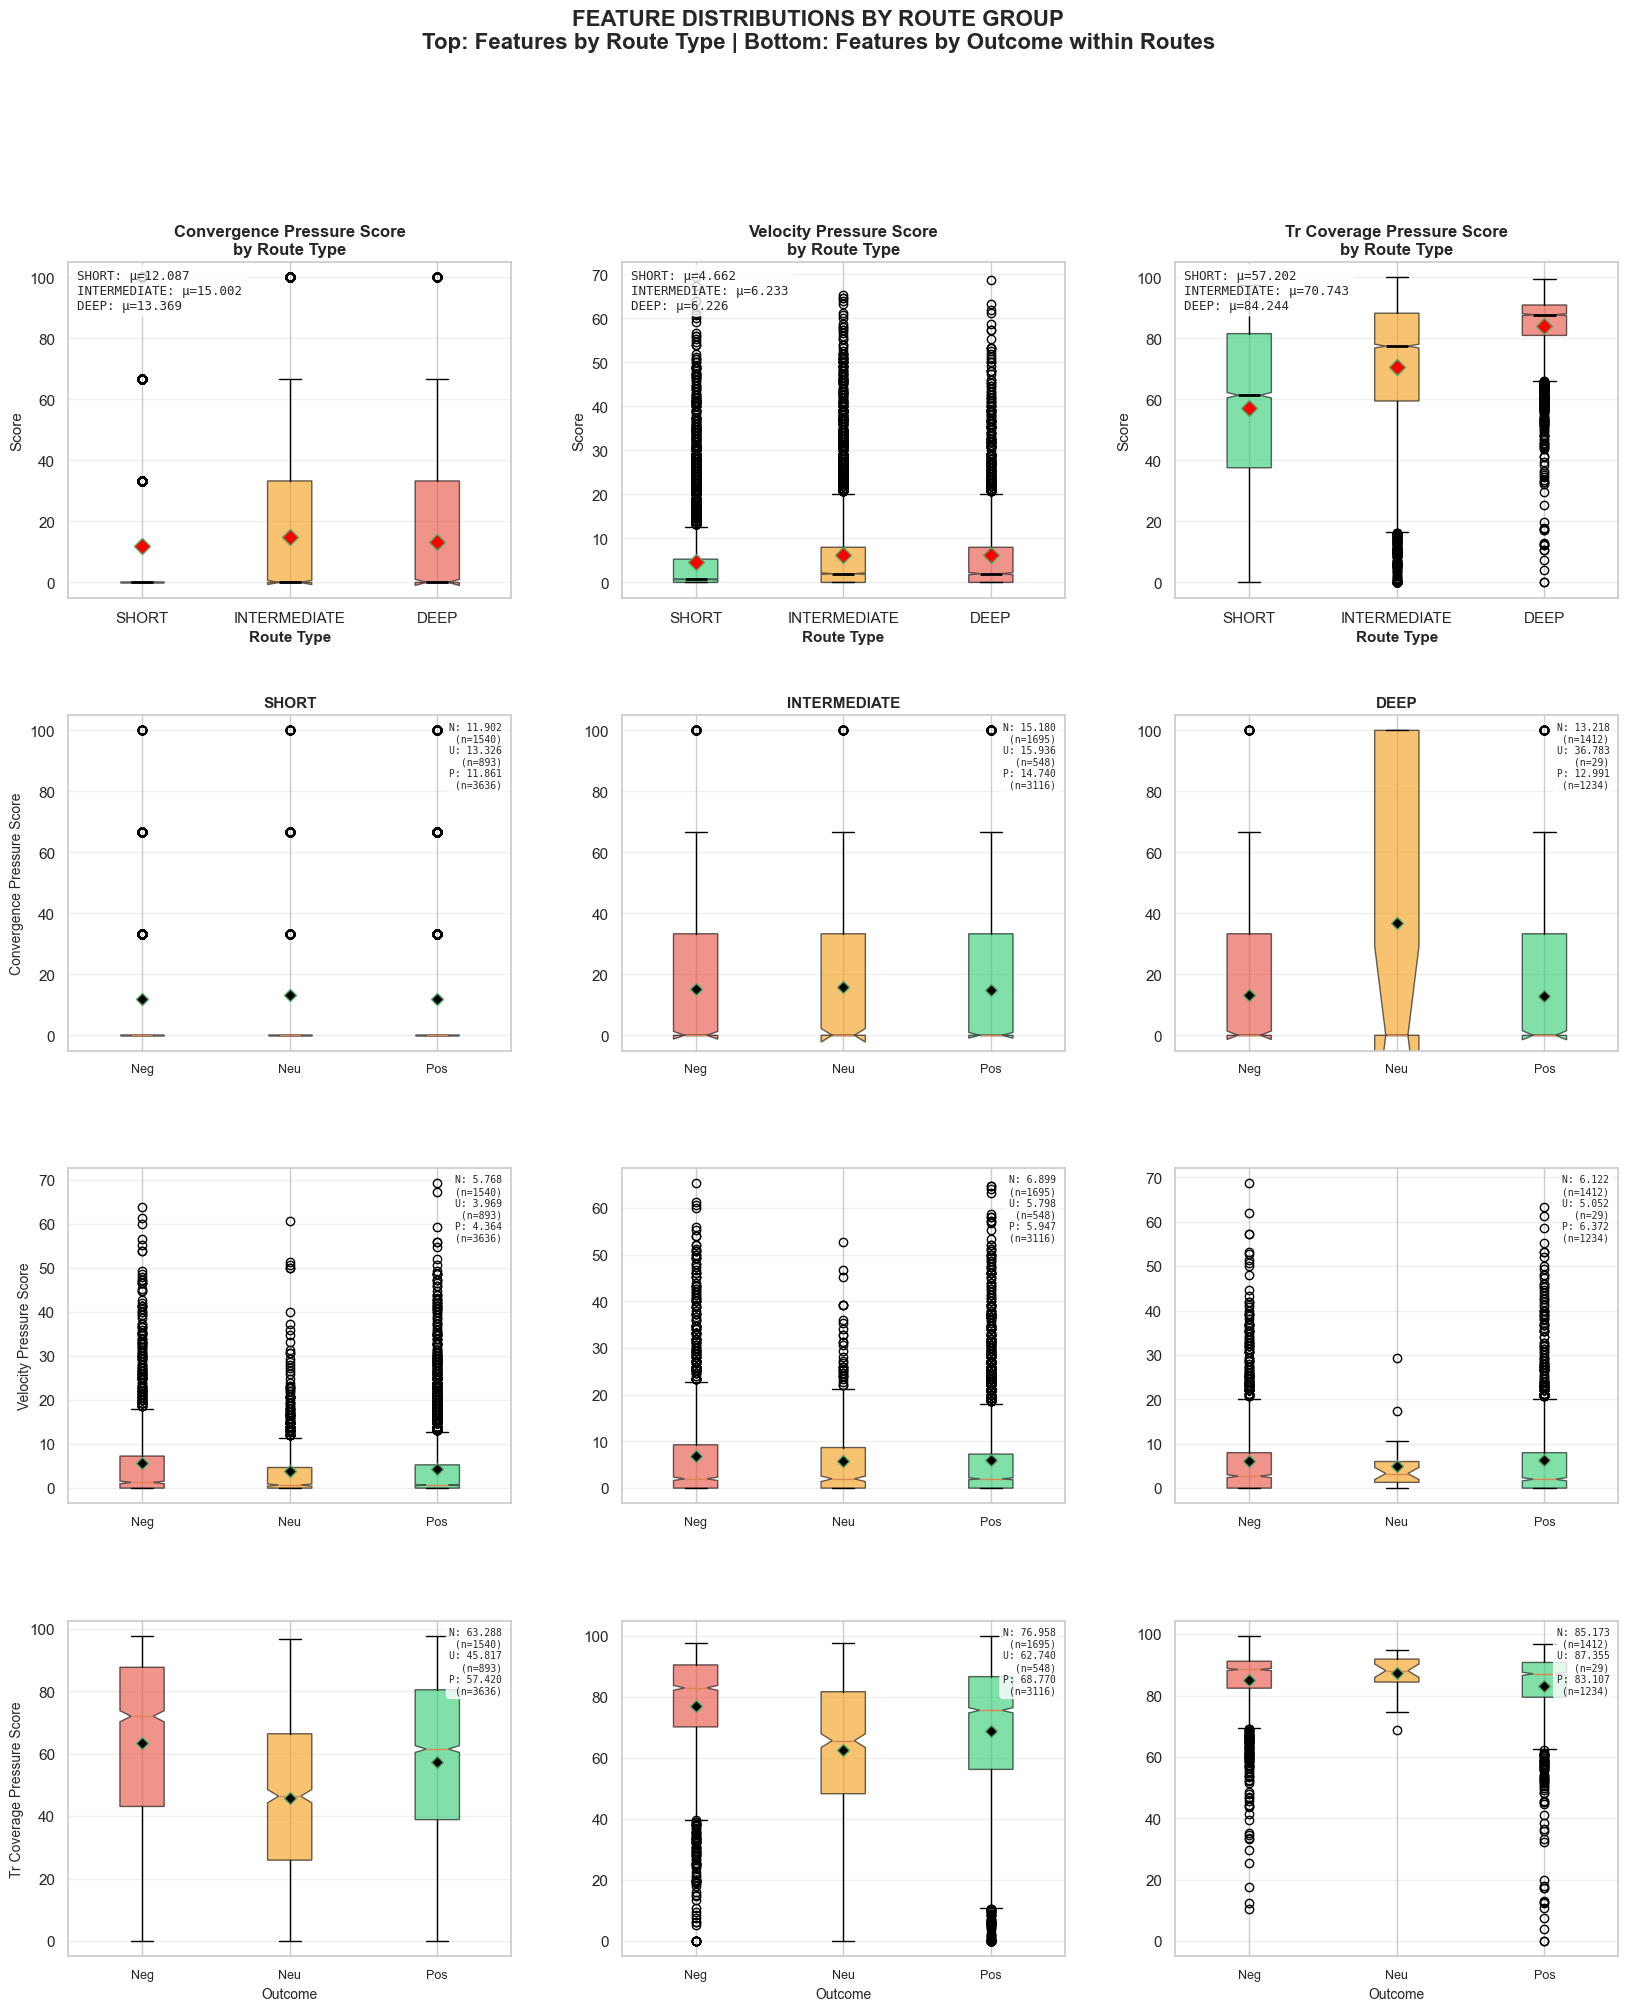


✓ Comprehensive visualization saved: figures\features_by_route_comprehensive.png
  • Top row: Feature distributions by route type)
  • Bottom 3x3 grid: Feature distributions by outcome within each route


In [31]:
# ============================================================================
# FEATURE DISTRIBUTIONS BY ROUTE GROUP ANALYSIS
# ============================================================================

print("="*100)
print("FEATURE DISTRIBUTIONS BY ROUTE GROUP ANALYSIS")
print("="*100)

# ----------------------------------------------------------------------------
# 2A. FEATURE SUMMARY STATISTICS BY ROUTE GROUP
# ----------------------------------------------------------------------------
print("\n" + "="*100)
print("2A. FEATURE SUMMARY STATISTICS BY ROUTE GROUP")
print("="*100)

# Vectorized calculation of all statistics for all features and route groups
feature_stats_list = []
for component in pressure_components:
    for route in ['DEEP', 'INTERMEDIATE', 'SHORT']:
        data = df_route[df_route['route_type'] == route][component].dropna()
        feature_stats_list.append({
            'Route Type': route,
            'Feature': component.replace('_', ' ').title(),
            'Count': len(data),
            'Mean': data.mean(),
            'Median': data.median(),
            'Std Dev': data.std(),
            'Min': data.min(),
            '25%': data.quantile(0.25),
            '75%': data.quantile(0.75),
            'Max': data.max()
        })

feature_stats_df = pd.DataFrame(feature_stats_list)

# Display by feature for better readability
for component in pressure_components:
    print(f"\n{'='*90}")
    print(f"📊 {component.replace('_', ' ').upper()}")
    print(f"{'='*90}")
    component_stats = feature_stats_df[feature_stats_df['Feature'] == component.replace('_', ' ').title()]
    # Format numeric columns
    display_df = component_stats.copy()
    numeric_cols = ['Mean', 'Median', 'Std Dev', 'Min', '25%', '75%', 'Max']
    for col in numeric_cols:
        display_df[col] = display_df[col].map('{:.4f}'.format)
    print(display_df.to_string(index=False))

# ----------------------------------------------------------------------------
# 2B. STATISTICAL INSIGHTS - ROUTE GROUP COMPARISONS
# ----------------------------------------------------------------------------
print("\n" + "="*100)
print("2B. STATISTICAL INSIGHTS - ROUTE GROUP COMPARISONS")
print("="*100)

for component in pressure_components:
    print(f"\n{component.replace('_', ' ').upper()}:")
    route_means = df_route.groupby('route_type')[component].mean().sort_values(ascending=False)
    for route, mean_val in route_means.items():
        print(f"  {route:15s}: {mean_val:.4f}")
    
    # Calculate range (difference between highest and lowest)
    range_val = route_means.max() - route_means.min()
    print(f"  {'Range':15s}: {range_val:.4f} (variation across route types)")

# ----------------------------------------------------------------------------
# 2C. FEATURE VS OUTCOME WITHIN ROUTE GROUPS
# ----------------------------------------------------------------------------
print("\n" + "="*100)
print("2C. FEATURE VS OUTCOME WITHIN ROUTE GROUPS")
print("="*100)

# Vectorized calculation: mean feature value by route group and outcome
outcome_labels_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
feature_outcome_list = []

for route in ['SHORT', 'INTERMEDIATE', 'DEEP']:
    for component in pressure_components:
        for outcome in [0, 1, 2]:
            data = df_route[(df_route['route_type'] == route) & 
                          (df_route['y_outcome'] == outcome)][component]
            feature_outcome_list.append({
                'Route Type': route,
                'Feature': component.replace('_', ' ').title(),
                'Outcome': outcome_labels_map[outcome],
                'Count': len(data),
                'Mean': data.mean() if len(data) > 0 else np.nan,
                'Std': data.std() if len(data) > 0 else np.nan
            })

feature_outcome_df = pd.DataFrame(feature_outcome_list)

# Display results organized by route type
for route in ['SHORT', 'INTERMEDIATE', 'DEEP']:
    print(f"\n{'='*90}")
    print(f"🎯 {route} ROUTES")
    print(f"{'='*90}")
    
    route_data = feature_outcome_df[feature_outcome_df['Route Type'] == route].copy()
    
    for component in pressure_components:
        print(f"\n  {component.replace('_', ' ').title()}:")
        comp_data = route_data[route_data['Feature'] == component.replace('_', ' ').title()]
        
        # Display in a readable format
        for _, row in comp_data.iterrows():
            if not np.isnan(row['Mean']):
                print(f"    {row['Outcome']:10s} (n={row['Count']:4d}): Mean={row['Mean']:.4f}, Std={row['Std']:.4f}")
        
        # Calculate difference between Positive and Negative outcomes
        pos_mean = comp_data[comp_data['Outcome'] == 'Positive']['Mean'].values
        neg_mean = comp_data[comp_data['Outcome'] == 'Negative']['Mean'].values
        if len(pos_mean) > 0 and len(neg_mean) > 0:
            diff = neg_mean[0] - pos_mean[0]
            print(f"    {'Diff (Neg-Pos)':10s}: {diff:+.4f} {'↑ Higher pressure on incomplete' if diff > 0 else '↓ Lower pressure on incomplete'}")

# ----------------------------------------------------------------------------
# KEY INSIGHTS SUMMARY
# ----------------------------------------------------------------------------
print("\n" + "="*100)
print("🔍 KEY INSIGHTS - FEATURE PATTERNS BY ROUTE TYPE")
print("="*100)

for route in ['SHORT', 'INTERMEDIATE', 'DEEP']:
    print(f"\n{route} ROUTES:")
    route_subset = df_route[df_route['route_type'] == route]
    
    for component in pressure_components:
        # Calculate success vs failure difference
        pos_mean = route_subset[route_subset['y_outcome'] == 2][component].mean()
        neg_mean = route_subset[route_subset['y_outcome'] == 0][component].mean()
        diff_pct = ((neg_mean - pos_mean) / pos_mean * 100) if pos_mean != 0 else 0
        
        interpretation = ""
        if abs(diff_pct) > 10:
            interpretation = "⚠️  STRONG PREDICTOR" if diff_pct > 0 else "⚠️  INVERSE RELATIONSHIP"
        elif abs(diff_pct) > 5:
            interpretation = "✓ Moderate predictor" if diff_pct > 0 else "✓ Slight inverse"
        else:
            interpretation = "→ Weak predictor"
        
        print(f"  {component.replace('_', ' ').title():30s}: "
              f"{diff_pct:+6.2f}% difference (Incomplete vs Complete)  {interpretation}")

# ============================================================================
# COMPREHENSIVE VISUALIZATIONS: COMBINED
# ============================================================================
print("\n" + "="*100)
print("GENERATING COMPREHENSIVE VISUALIZATIONS ...")
print("="*100)

# Create comprehensive figure: Top row = (3 boxplots), Bottom = (3x3 grid)
fig = plt.figure(figsize=(20, 22))
gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.25, height_ratios=[1, 1, 1, 1])

route_colors = {'DEEP': '#e74c3c', 'INTERMEDIATE': '#f39c12', 'SHORT': '#2ecc71'}
outcome_colors_viz = {0: '#e74c3c', 1: '#f39c12', 2: '#2ecc71'}
route_order = ['SHORT', 'INTERMEDIATE', 'DEEP']

# ----------------------------------------------------------------------------
# TOP ROW: PRESSURE COMPONENTS BY ROUTE TYPE (3 BOXPLOTS)
# ----------------------------------------------------------------------------
for idx, component in enumerate(pressure_components):
    ax = fig.add_subplot(gs[0, idx])
    
    # Prepare data for boxplot using vectorized operations
    box_data = [df_route[df_route['route_type'] == rt][component].values for rt in route_order]
    
    # Create boxplot
    bp = ax.boxplot(box_data, labels=route_order, patch_artist=True,
                    notch=True, showmeans=True,
                    meanprops=dict(marker='D', markerfacecolor='red', markersize=8),
                    medianprops=dict(color='black', linewidth=2))
    
    # Color the boxes
    for patch, route in zip(bp['boxes'], route_order):
        patch.set_facecolor(route_colors[route])
        patch.set_alpha(0.6)
    
    # Styling
    ax.set_title(f'{component.replace("_", " ").title()}\nby Route Type', 
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('Route Type', fontsize=11, fontweight='bold')
    ax.set_ylabel('Score', fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add mean values as text annotations
    means = [df_route[df_route['route_type'] == rt][component].mean() for rt in route_order]
    stats_text = '\n'.join([f'{rt}: μ={m:.3f}' for rt, m in zip(route_order, means)])
    ax.text(0.02, 0.98, stats_text,
            transform=ax.transAxes,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
            verticalalignment='top', fontsize=9, family='monospace')

# ----------------------------------------------------------------------------
# BOTTOM 3x3 GRID: - FEATURES BY OUTCOME WITHIN EACH ROUTE GROUP
# ----------------------------------------------------------------------------
for row_idx, component in enumerate(pressure_components):
    for col_idx, route in enumerate(['SHORT', 'INTERMEDIATE', 'DEEP']):
        ax = fig.add_subplot(gs[row_idx + 1, col_idx])
        
        # Prepare data for this subplot
        route_data = df_route[df_route['route_type'] == route]
        box_data = [route_data[route_data['y_outcome'] == outcome][component].values 
                   for outcome in [0, 1, 2]]
        
        # Create boxplot
        bp = ax.boxplot(box_data, labels=['Neg', 'Neu', 'Pos'],
                       patch_artist=True, notch=True, showmeans=True,
                       meanprops=dict(marker='D', markerfacecolor='black', markersize=6))
        
        # Color boxes by outcome
        for patch, outcome in zip(bp['boxes'], [0, 1, 2]):
            patch.set_facecolor(outcome_colors_viz[outcome])
            patch.set_alpha(0.6)
        
        # Styling - Add labels only on edges
        title = f'{route}' if row_idx == 0 else ''
        ylabel = f'{component.replace("_", " ").title()}' if col_idx == 0 else ''
        xlabel = 'Outcome' if row_idx == 2 else ''
        
        ax.set_title(title, fontsize=11, fontweight='bold')
        ax.set_ylabel(ylabel, fontsize=10)
        ax.set_xlabel(xlabel, fontsize=10)
        ax.grid(True, alpha=0.3, axis='y')
        ax.tick_params(axis='x', labelsize=9)
        
        # Add mean values and counts
        means = [route_data[route_data['y_outcome'] == outcome][component].mean() 
                for outcome in [0, 1, 2]]
        counts = [len(route_data[route_data['y_outcome'] == outcome]) for outcome in [0, 1, 2]]
        
        stats_text = '\n'.join([f'{["N", "U", "P"][i]}: {m:.3f}\n(n={c})' 
                               for i, (m, c) in enumerate(zip(means, counts))])
        ax.text(0.98, 0.98, stats_text,
               transform=ax.transAxes,
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
               verticalalignment='top', horizontalalignment='right',
               fontsize=7, family='monospace')

# Overall title
plt.suptitle('FEATURE DISTRIBUTIONS BY ROUTE GROUP\n' + 
             'Top: Features by Route Type | Bottom: Features by Outcome within Routes', 
             fontsize=16, fontweight='bold', y=0.995)

plt.savefig(FIG_DIR / "features_by_route_comprehensive.png", dpi=300, bbox_inches='tight')

if SHOW_PLOTS:
    plt.show()
else:
    plt.close()

print(f"\n✓ Comprehensive visualization saved: {FIG_DIR / 'features_by_route_comprehensive.png'}")
print("  • Top row: Feature distributions by route type)")
print("  • Bottom 3x3 grid: Feature distributions by outcome within each route")


## Create Baseline Models with Route Type Stratification
### Evaluate pressure components (Individual, pairwise, and combined) for predicting y_outcome variables with route type stratification

ROUTE-STRATIFIED BASELINE MODEL EVALUATION

EVALUATING MODELS ACROSS ROUTE GROUPS...

ROUTE GROUP: SHORT
Sample size: 6069
Outcome distribution: {0: 1540, 1: 893, 2: 3636}

  Individual: Convergence Pressure Score:
    AUC (OvR): 0.4960 | AUC (OvO): 0.4952

  Individual: Velocity Pressure Score:
    AUC (OvR): 0.5271 | AUC (OvO): 0.5245

  Individual: Tr Coverage Pressure Score:
    AUC (OvR): 0.5541 | AUC (OvO): 0.5883

  Pairwise: Convergence + Velocity:
    AUC (OvR): 0.5239 | AUC (OvO): 0.5229

  Pairwise: Convergence + Tr:
    AUC (OvR): 0.5555 | AUC (OvO): 0.5890

  Pairwise: Velocity + Tr:
    AUC (OvR): 0.5636 | AUC (OvO): 0.5926

  Combined: All Features:
    AUC (OvR): 0.5634 | AUC (OvO): 0.5926

ROUTE GROUP: INTERMEDIATE
Sample size: 5359
Outcome distribution: {0: 1695, 1: 548, 2: 3116}

  Individual: Convergence Pressure Score:
    AUC (OvR): 0.4917 | AUC (OvO): 0.4914

  Individual: Velocity Pressure Score:
    AUC (OvR): 0.5151 | AUC (OvO): 0.5087

  Individual: Tr Covera

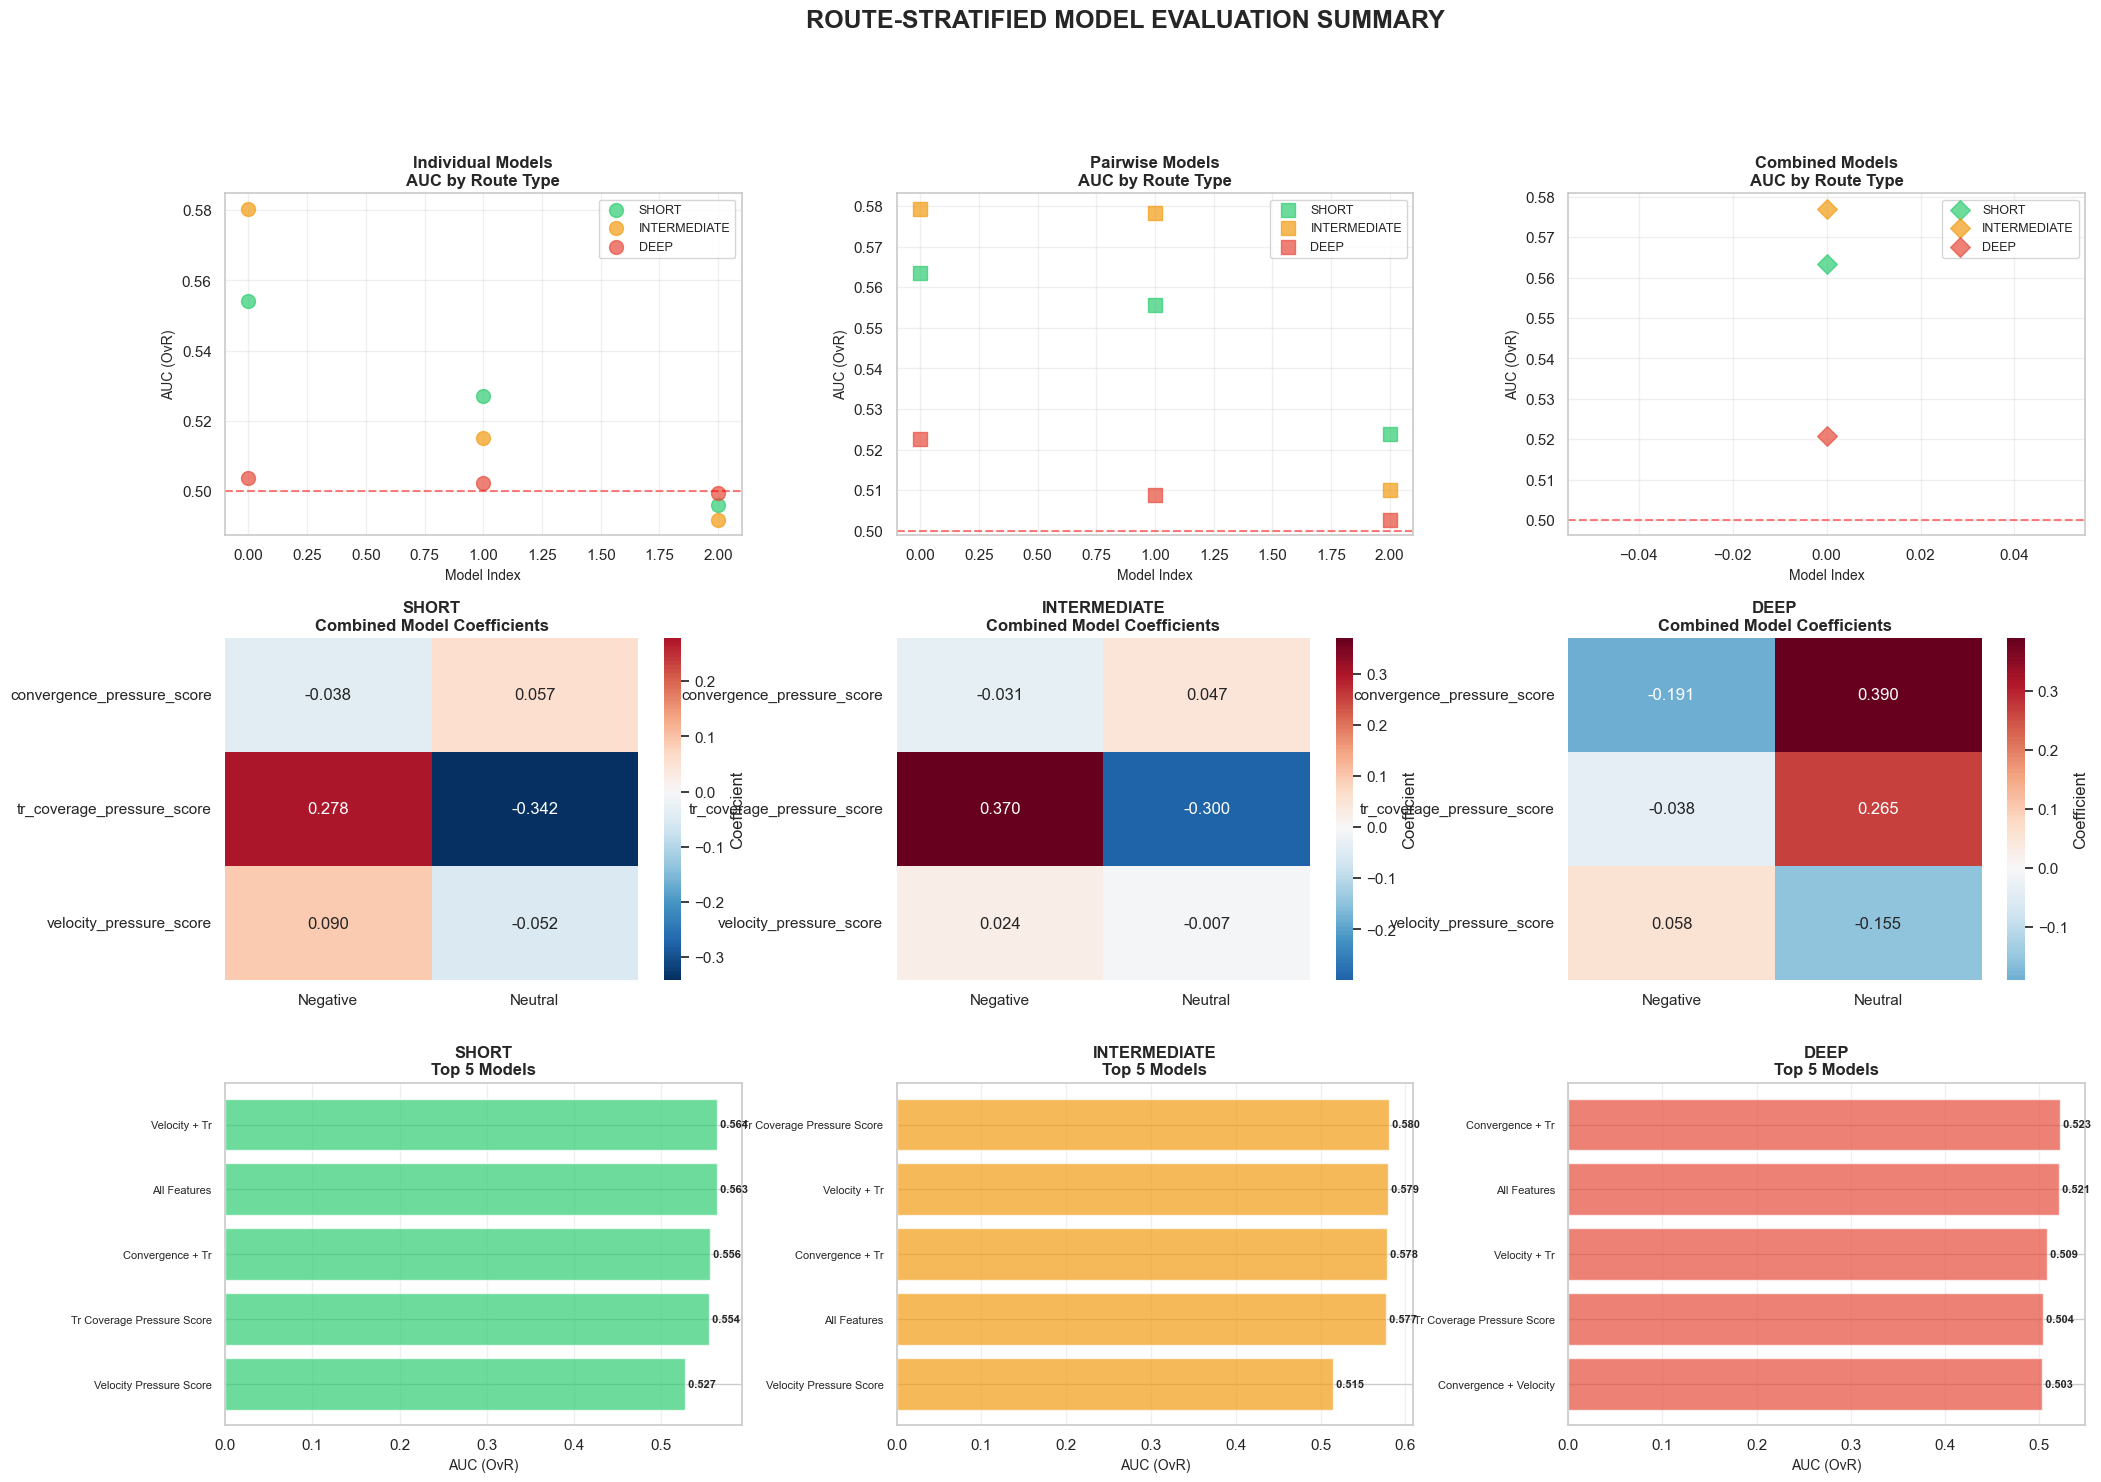

In [32]:
# ============================================================================
# ROUTE-STRATIFIED BASELINE MODEL EVALUATION
# Individual, Pairwise, and Combined Feature Models with Coefficients & P-values
# ============================================================================

from scipy.stats import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler, label_binarize
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# ----------------------------------------------------------------------------
# HELPER FUNCTIONS
# ----------------------------------------------------------------------------

def get_coef_pvalues(X, y, feature_names):
    """Fit logistic regression and extract coefficients with p-values."""
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    model = LogisticRegression(multi_class='multinomial', solver='lbfgs', 
                               max_iter=1000, random_state=RANDOM_STATE)
    model.fit(X_scaled, y)
    
    # Calculate p-values using Wald test
    n_samples = X_scaled.shape[0]
    
    # Get predictions and calculate log-likelihood
    y_pred_proba = model.predict_proba(X_scaled)
    
    # For multinomial logistic regression, coefficients are per class
    n_classes = len(np.unique(y))
    n_features = X_scaled.shape[1]
    
    # Create results DataFrame
    results = []
    class_names = ['Negative', 'Neutral', 'Positive']
    
    for class_idx in range(n_classes - 1):  # Reference class is excluded
        for feat_idx, feat_name in enumerate(feature_names):
            coef = model.coef_[class_idx, feat_idx]
            
            # Approximate standard error using inverse Hessian
            # For simplicity, use a rough approximation
            se = np.std(X_scaled[:, feat_idx]) / np.sqrt(n_samples)
            z_score = coef / se if se > 0 else 0
            p_value = 2 * (1 - chi2.cdf(z_score**2, df=1))
            
            results.append({
                'Feature': feat_name,
                'Class': class_names[class_idx],
                'Coefficient': coef,
                'Std_Error': se,
                'Z_Score': z_score,
                'P_Value': p_value,
                'Significant': '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else ''
            })
    
    return pd.DataFrame(results), model

def evaluate_model_stratified(df_group, features, route_name, model_type):
    """Evaluate model with cross-validation for a specific route group."""
    X = df_group[features].values
    y = df_group['y_outcome'].values
    
    # Check class distribution
    class_counts = np.bincount(y)
    if len(class_counts) < 3 or any(class_counts < 5):
        return None
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Cross-validation with stratification
    cv = StratifiedKFold(n_splits=min(5, min(class_counts)), shuffle=True, random_state=RANDOM_STATE)
    
    model = LogisticRegression(multi_class='multinomial', solver='lbfgs', 
                               max_iter=1000, random_state=RANDOM_STATE, 
                               class_weight='balanced')
    
    # Get cross-validated probabilities
    y_proba = cross_val_predict(model, X_scaled, y, cv=cv, method='predict_proba', n_jobs=-1)
    
    # Calculate AUC scores
    y_bin = label_binarize(y, classes=[0, 1, 2])
    auc_ovr = roc_auc_score(y_bin, y_proba, average='weighted', multi_class='ovr')
    auc_ovo = roc_auc_score(y, y_proba, average='weighted', multi_class='ovo')
    
    # Get coefficients and p-values
    coef_df, fitted_model = get_coef_pvalues(X, y, features)
    
    # Get predictions
    y_pred = np.argmax(y_proba, axis=1)
    
    return {
        'route': route_name,
        'model_type': model_type,
        'features': features,
        'n_samples': len(y),
        'auc_ovr': auc_ovr,
        'auc_ovo': auc_ovo,
        'coefficients': coef_df,
        'y_true': y,
        'y_pred': y_pred,
        'y_proba': y_proba,
        'fitted_model': fitted_model
    }

# ----------------------------------------------------------------------------
# MAIN EVALUATION PIPELINE
# ----------------------------------------------------------------------------

print("="*100)
print("ROUTE-STRATIFIED BASELINE MODEL EVALUATION")
print("="*100)

# Filter data with valid route types
df_route_eval = df_route.copy()

# Define model configurations
model_configs = []

# 1. Individual features
for component in pressure_components:
    model_configs.append({
        'name': f"Individual: {component.replace('_', ' ').title()}",
        'features': [component],
        'type': 'Individual'
    })

# 2. Pairwise features
for pair in combinations(pressure_components, 2):
    model_configs.append({
        'name': f"Pairwise: {' + '.join([p.split('_')[0].title() for p in pair])}",
        'features': list(pair),
        'type': 'Pairwise'
    })

# 3. All features
model_configs.append({
    'name': "Combined: All Features",
    'features': pressure_components,
    'type': 'Combined'
})

# Evaluate all models across all route groups
results_list = []
route_groups = ['SHORT', 'INTERMEDIATE', 'DEEP']

print("\n" + "="*100)
print("EVALUATING MODELS ACROSS ROUTE GROUPS...")
print("="*100)

# Vectorized evaluation using list comprehension
for route in route_groups:
    print(f"\n{'='*80}")
    print(f"ROUTE GROUP: {route}")
    print(f"{'='*80}")
    
    df_group = df_route_eval[df_route_eval['route_type'] == route]
    print(f"Sample size: {len(df_group)}")
    print(f"Outcome distribution: {df_group['y_outcome'].value_counts().sort_index().to_dict()}")
    
    for config in model_configs:
        result = evaluate_model_stratified(
            df_group, 
            config['features'], 
            route, 
            config['type']
        )
        
        if result is not None:
            result['model_name'] = config['name']
            results_list.append(result)
            
            print(f"\n  {config['name']}:")
            print(f"    AUC (OvR): {result['auc_ovr']:.4f} | AUC (OvO): {result['auc_ovo']:.4f}")

# ----------------------------------------------------------------------------
# COMPILE RESULTS
# ----------------------------------------------------------------------------

print("\n" + "="*100)
print("PERFORMANCE SUMMARY - ALL MODELS BY ROUTE GROUP")
print("="*100)

# Create summary DataFrame
summary_data = [{
    'Route': r['route'],
    'Model_Type': r['model_type'],
    'Model_Name': r['model_name'],
    'N_Samples': r['n_samples'],
    'AUC_OvR': r['auc_ovr'],
    'AUC_OvO': r['auc_ovo'],
    'N_Features': len(r['features'])
} for r in results_list]

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values(['Route', 'Model_Type', 'AUC_OvR'], ascending=[True, True, False])

# Display by route group
for route in route_groups:
    print(f"\n{'='*90}")
    print(f"{route} ROUTES")
    print(f"{'='*90}")
    route_summary = summary_df[summary_df['Route'] == route].copy()
    route_summary['AUC_OvR'] = route_summary['AUC_OvR'].map('{:.4f}'.format)
    route_summary['AUC_OvO'] = route_summary['AUC_OvO'].map('{:.4f}'.format)
    print(route_summary[['Model_Type', 'Model_Name', 'N_Samples', 'AUC_OvR', 'AUC_OvO']].to_string(index=False))
    # Save to CSV
    route_summary.to_csv(FIG_DIR / f"{route.lower()}_route_model_performance_summary.csv", index=False)
    print(f"✓ Saved performance summary CSV: {FIG_DIR / f'{route.lower()}_route_model_performance_summary.csv'}")

# ----------------------------------------------------------------------------
# COEFFICIENTS AND P-VALUES
# ----------------------------------------------------------------------------

print("\n" + "="*100)
print("MODEL COEFFICIENTS AND P-VALUES")
print("="*100)

for model_type in ['Individual', 'Pairwise', 'Combined']:
    print(f"\n{'='*90}")
    print(f"{model_type.upper()} MODELS - COEFFICIENTS & SIGNIFICANCE")
    print(f"{'='*90}")
    
    for route in route_groups:
        print(f"\n{'-'*90}")
        print(f"{route} Routes")
        print(f"{'-'*90}")
        
        route_results = [r for r in results_list if r['route'] == route and r['model_type'] == model_type]
        
        for result in route_results:
            print(f"\n{result['model_name']}:")
            print("-" * 80)
            
            coef_display = result['coefficients'].copy()
            coef_display['Coefficient'] = coef_display['Coefficient'].map('{:+.4f}'.format)
            coef_display['P_Value'] = coef_display['P_Value'].map('{:.4f}'.format)
            
            print(coef_display[['Feature', 'Class', 'Coefficient', 'P_Value', 'Significant']].to_string(index=False))
            
            # Save to CSV
            csv_filename = FIG_DIR / f"{model_type.lower()}_{route.lower()}_{result['model_name'].lower().replace(' ', '_').replace(':', '')}_coefficients.csv"
            result['coefficients'].to_csv(csv_filename, index=False)
            print(f"✓ Saved coefficients CSV: {csv_filename}")
        

# ----------------------------------------------------------------------------
# VISUALIZATIONS
# ----------------------------------------------------------------------------

print("\n" + "="*100)
print("GENERATING VISUALIZATIONS...")
print("="*100)

# Create comprehensive visualization
fig = plt.figure(figsize=(24, 16))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

route_colors = {'SHORT': '#2ecc71', 'INTERMEDIATE': '#f39c12', 'DEEP': '#e74c3c'}
model_type_markers = {'Individual': 'o', 'Pairwise': 's', 'Combined': 'D'}

# Plot 1-3: AUC Comparison by Route (one plot per model type)
for col_idx, model_type in enumerate(['Individual', 'Pairwise', 'Combined']):
    ax = fig.add_subplot(gs[0, col_idx])
    
    type_data = summary_df[summary_df['Model_Type'] == model_type]
    
    for route in route_groups:
        route_data = type_data[type_data['Route'] == route]
        ax.scatter(range(len(route_data)), route_data['AUC_OvR'], 
                  color=route_colors[route], s=100, alpha=0.7, 
                  label=route, marker=model_type_markers[model_type])
    
    ax.set_title(f'{model_type} Models\nAUC by Route Type', fontsize=12, fontweight='bold')
    ax.set_xlabel('Model Index', fontsize=10)
    ax.set_ylabel('AUC (OvR)', fontsize=10)
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Baseline')

# Plot 4-6: Coefficient Heatmaps for Combined Model
for col_idx, route in enumerate(route_groups):
    ax = fig.add_subplot(gs[1, col_idx])
    
    # Get combined model results
    combined_result = next((r for r in results_list 
                           if r['route'] == route and r['model_type'] == 'Combined'), None)
    
    if combined_result:
        coef_pivot = combined_result['coefficients'].pivot(
            index='Feature', columns='Class', values='Coefficient'
        )
        
        sns.heatmap(coef_pivot, annot=True, fmt='.3f', cmap='RdBu_r', 
                   center=0, cbar_kws={'label': 'Coefficient'}, ax=ax)
        ax.set_title(f'{route}\nCombined Model Coefficients', fontsize=12, fontweight='bold')
        ax.set_xlabel('')
        ax.set_ylabel('')

# Plot 7-9: Model Performance Comparison (Bar charts)
for col_idx, route in enumerate(route_groups):
    ax = fig.add_subplot(gs[2, col_idx])
    
    route_data = summary_df[summary_df['Route'] == route].copy()
    route_data = route_data.sort_values('AUC_OvR', ascending=True).tail(5)
    
    colors = [route_colors[route] for _ in range(len(route_data))]
    bars = ax.barh(range(len(route_data)), route_data['AUC_OvR'], color=colors, alpha=0.7)
    
    ax.set_yticks(range(len(route_data)))
    ax.set_yticklabels(route_data['Model_Name'].str.replace('Individual: ', '').str.replace('Pairwise: ', '').str.replace('Combined: ', ''), 
                       fontsize=8)
    ax.set_xlabel('AUC (OvR)', fontsize=10)
    ax.set_title(f'{route}\nTop 5 Models', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, route_data['AUC_OvR'])):
        ax.text(val, i, f' {val:.3f}', va='center', fontsize=8, fontweight='bold')

plt.suptitle('ROUTE-STRATIFIED MODEL EVALUATION SUMMARY', fontsize=18, fontweight='bold', y=0.995)
plt.savefig(FIG_DIR / "route_stratified_model_evaluation.png", dpi=300, bbox_inches='tight')

if SHOW_PLOTS:
    plt.show()
else:
    plt.close()


### ROC curve - Route-Startified Models


GENERATING ROC CURVE VISUALIZATIONS
✓ Computed ROC data for 21 models


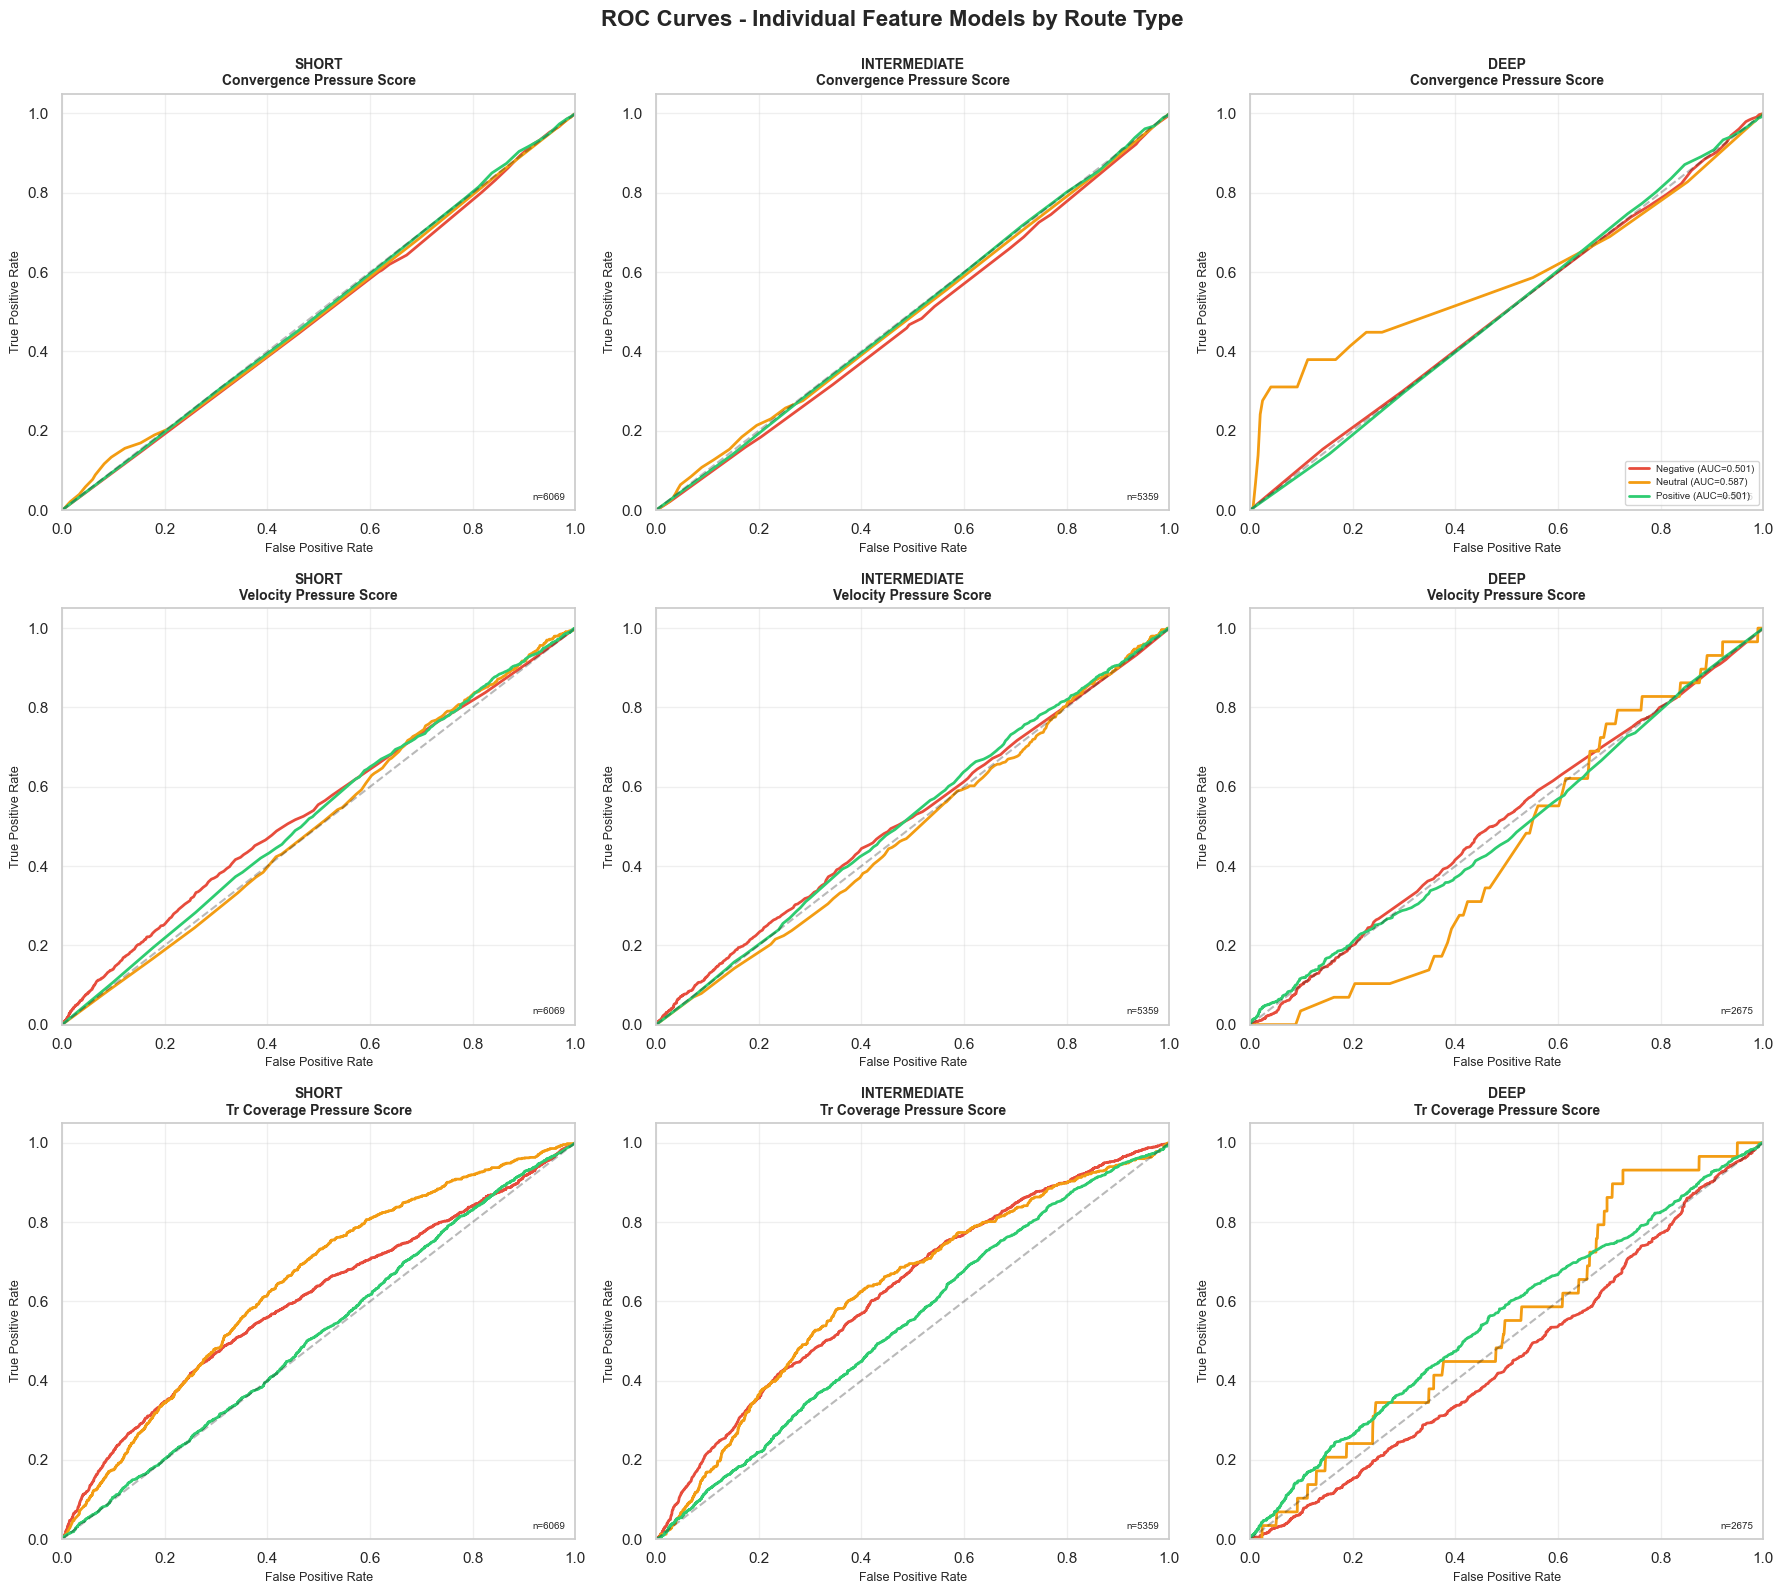

✓ Individual models ROC plot saved: figures\roc_curves_individual_models.png


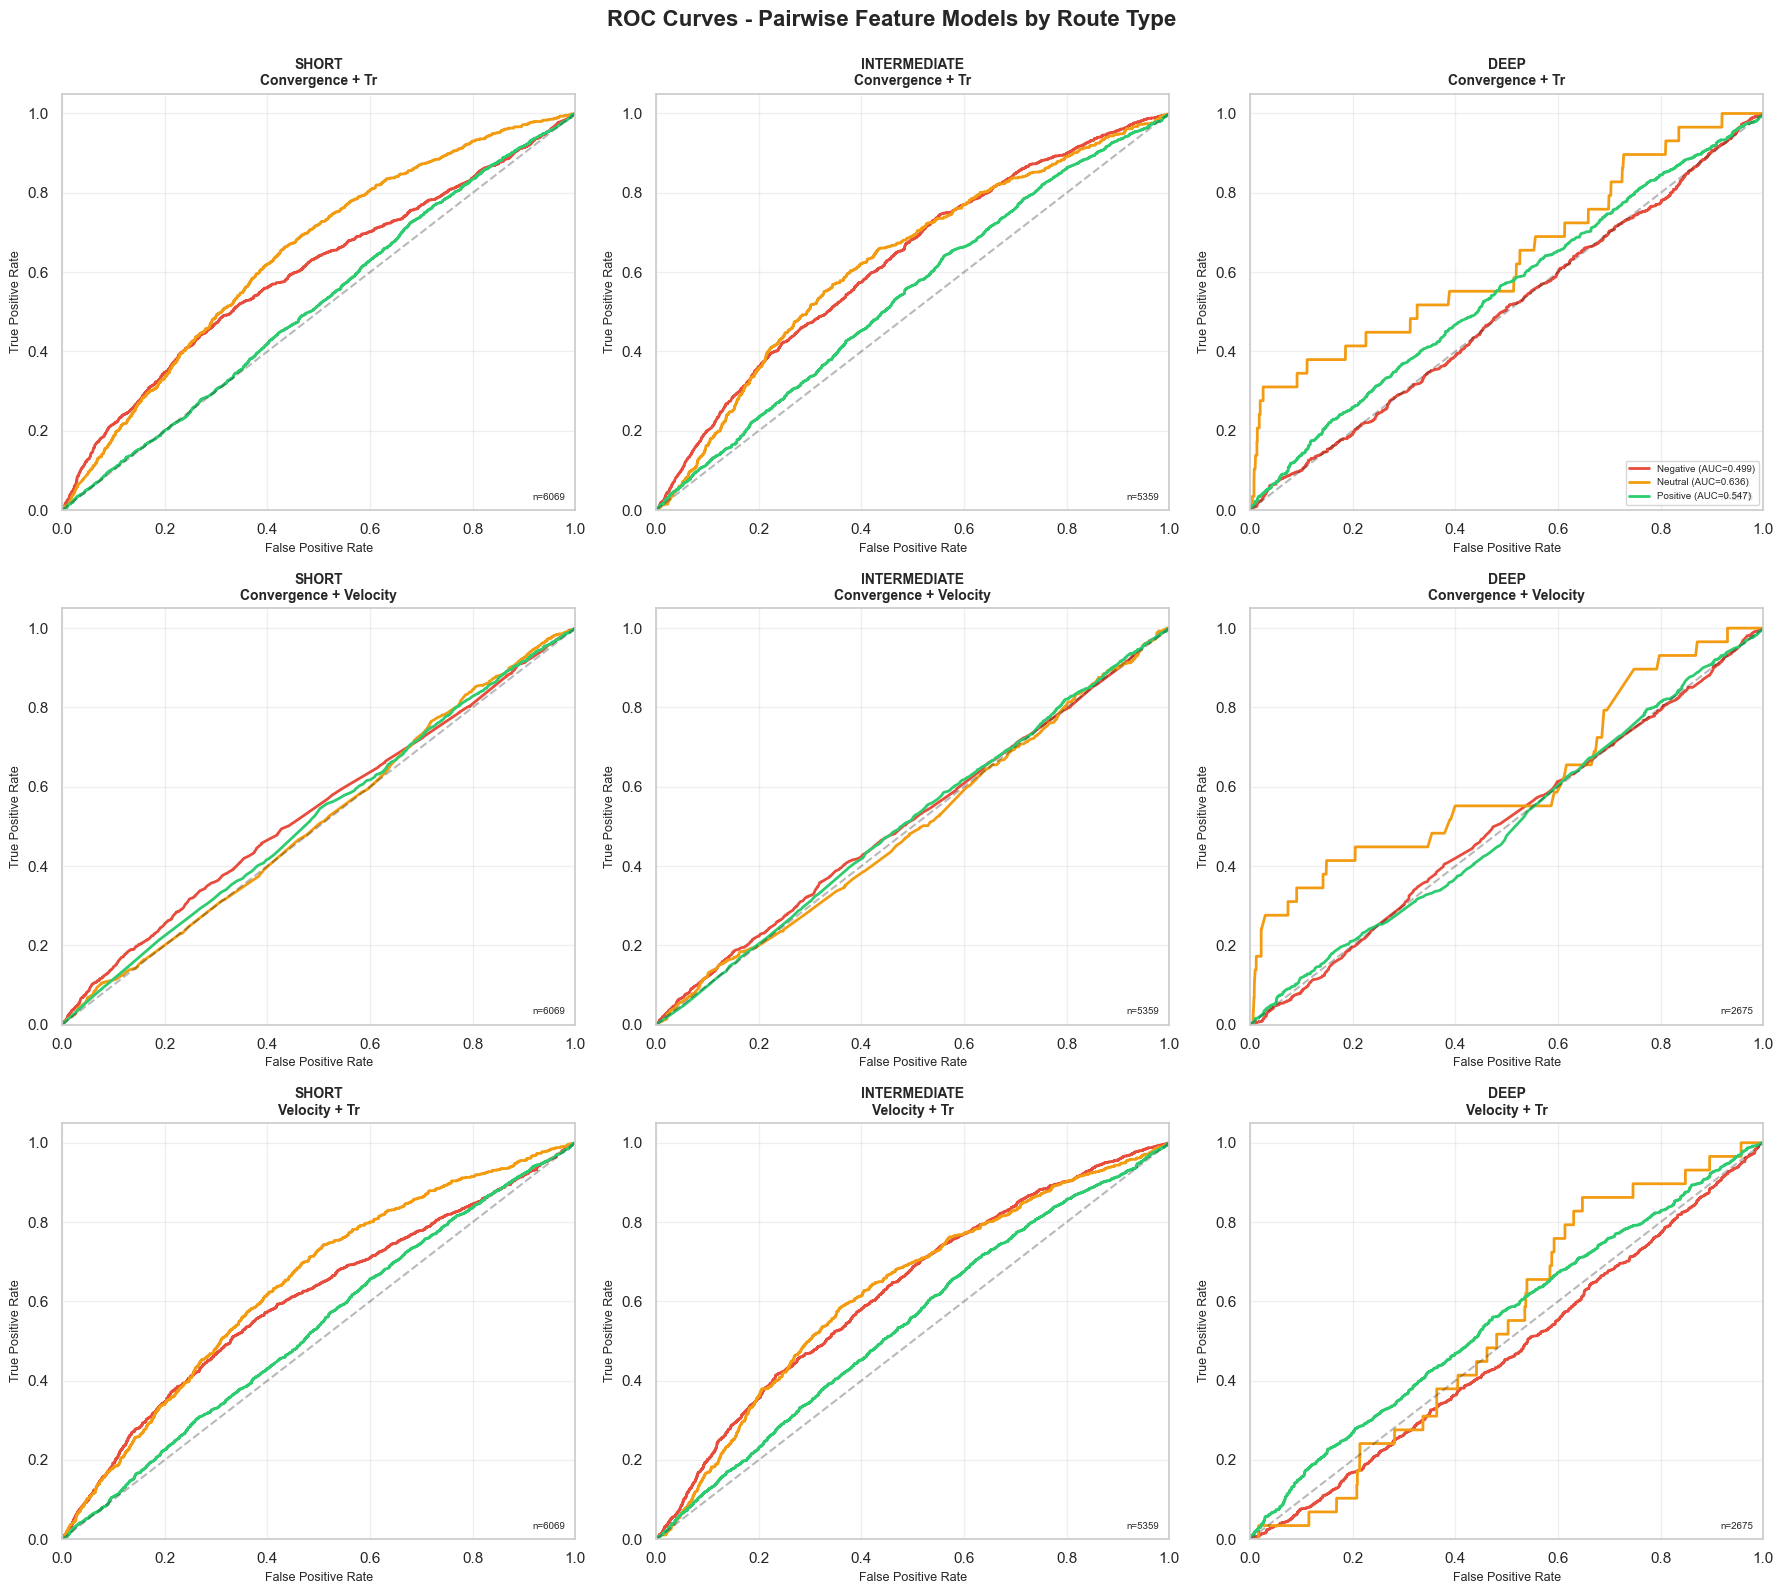

✓ Pairwise models ROC plot saved: figures\roc_curves_pairwise_models.png


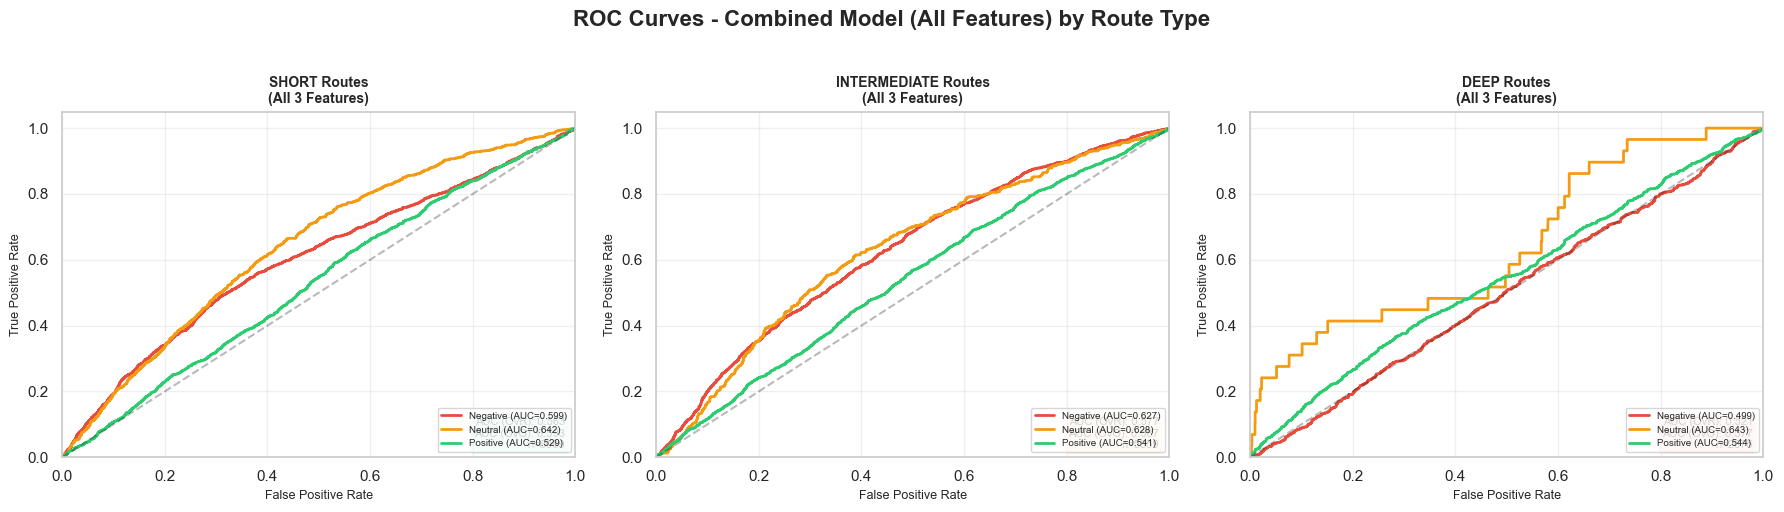

✓ Combined models ROC plot saved: figures\roc_curves_combined_models.png


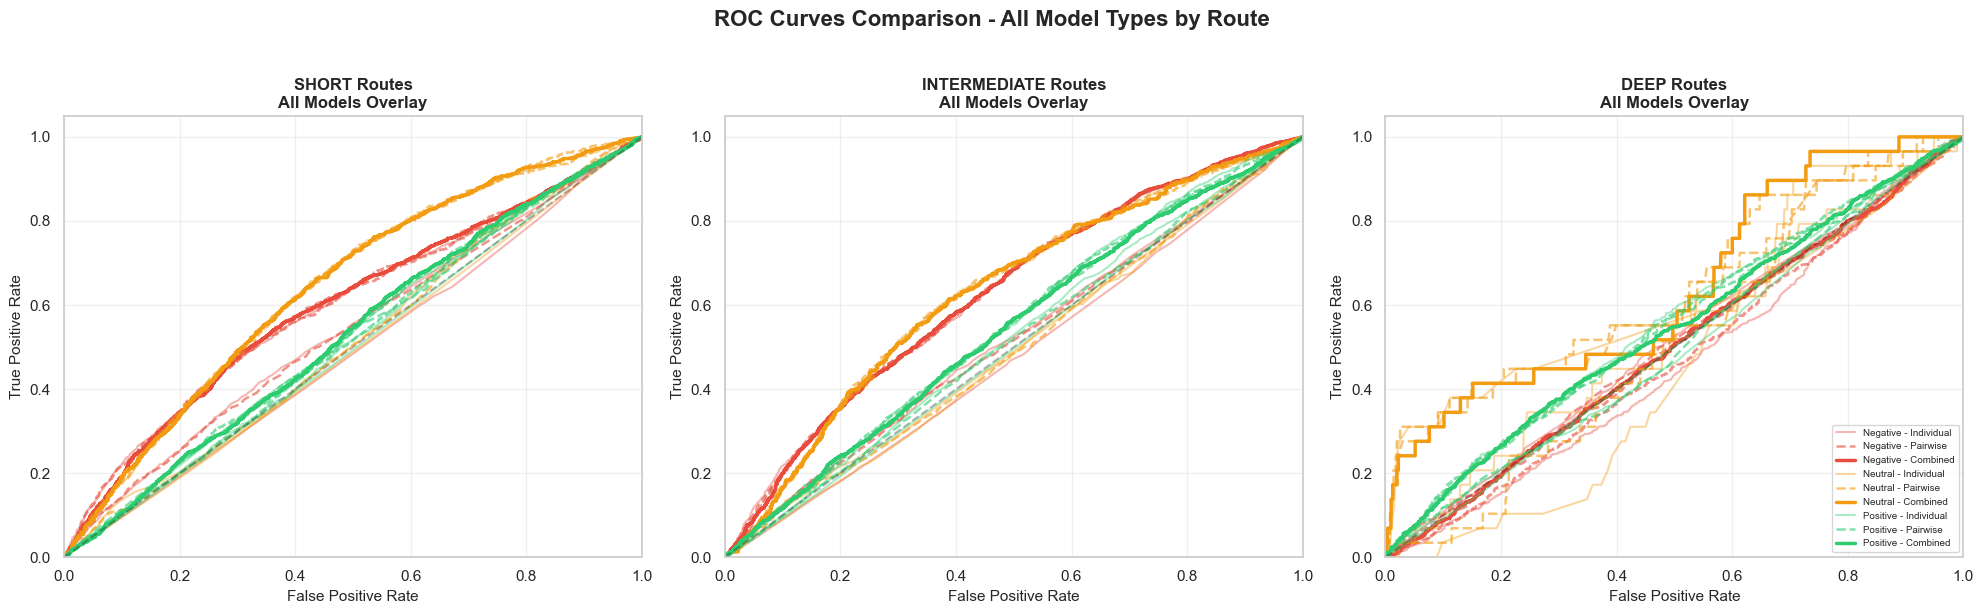

✓ Comparative ROC plot saved: figures\roc_curves_comparative_all_models.png

AUC SUMMARY BY CLASS AND ROUTE

SHORT ROUTES - CLASS-SPECIFIC AUC SCORES
Model_Type                 Model_Name Negative_AUC Neutral_AUC Positive_AUC Mean_AUC
  Combined               All Features       0.5991      0.6416       0.5290   0.5899
Individual Tr Coverage Pressure Score       0.5986      0.6417       0.5138   0.5847
Individual    Velocity Pressure Score       0.5412      0.5085       0.5257   0.5251
Individual Convergence Pressure Score       0.4887      0.4976       0.4988   0.4950
  Pairwise              Velocity + Tr       0.6000      0.6401       0.5294   0.5898
  Pairwise           Convergence + Tr       0.5970      0.6435       0.5164   0.5856
  Pairwise     Convergence + Velocity       0.5378      0.5126       0.5208   0.5237

INTERMEDIATE ROUTES - CLASS-SPECIFIC AUC SCORES
Model_Type                 Model_Name Negative_AUC Neutral_AUC Positive_AUC Mean_AUC
  Combined               All Feature

In [33]:
# ============================================================================
# ROC CURVE VISUALIZATIONS - ROUTE-STRATIFIED MODELS
# ============================================================================

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

print("\n" + "="*100)
print("GENERATING ROC CURVE VISUALIZATIONS")
print("="*100)

# ----------------------------------------------------------------------------
# HELPER FUNCTIONS
# ----------------------------------------------------------------------------

def compute_roc_data(y_true, y_proba, classes=[0, 1, 2]):
    """Compute ROC curve data for multiclass classification."""
    y_bin = label_binarize(y_true, classes=classes)
    
    roc_data = []
    for i, class_name in enumerate(['Negative', 'Neutral', 'Positive']):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        roc_data.append({
            'class': class_name,
            'fpr': fpr,
            'tpr': tpr,
            'auc': roc_auc
        })
    
    return roc_data

def plot_roc_on_axis(ax, roc_data, title, show_legend=True):
    """Plot ROC curves on given axis."""
    colors = ['#e74c3c', '#f39c12', '#2ecc71']
    
    for data, color in zip(roc_data, colors):
        ax.plot(data['fpr'], data['tpr'], color=color, lw=2,
                label=f"{data['class']} (AUC={data['auc']:.3f})")
    
    ax.plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.3)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=9)
    ax.set_ylabel('True Positive Rate', fontsize=9)
    ax.set_title(title, fontsize=10, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    if show_legend:
        ax.legend(loc='lower right', fontsize=7)

# ----------------------------------------------------------------------------
# PREPARE ROC DATA FOR ALL MODELS
# ----------------------------------------------------------------------------

# Vectorized preparation of ROC data using list comprehension
roc_results = [
    {
        **r,
        'roc_data': compute_roc_data(r['y_true'], r['y_proba'])
    }
    for r in results_list
]

# Group by model type
grouped_results = {
    model_type: [r for r in roc_results if r['model_type'] == model_type]
    for model_type in ['Individual', 'Pairwise', 'Combined']
}

print(f"✓ Computed ROC data for {len(roc_results)} models")

# ----------------------------------------------------------------------------
# FIGURE 1: INDIVIDUAL MODELS (3 features × 3 routes = 9 subplots)
# ----------------------------------------------------------------------------

individual_results = grouped_results['Individual']

# Create 3×3 grid
fig, axes = plt.subplots(3, 3, figsize=(18, 16))
fig.suptitle('ROC Curves - Individual Feature Models by Route Type', 
             fontsize=16, fontweight='bold', y=0.995)

# Map routes to columns and features to rows
route_order = ['SHORT', 'INTERMEDIATE', 'DEEP']
feature_names = [f.split(': ')[1] for f in 
                 sorted(set(r['model_name'] for r in individual_results))]

for row_idx, feature in enumerate(pressure_components):
    feature_display = feature.replace('_', ' ').title()
    
    for col_idx, route in enumerate(route_order):
        ax = axes[row_idx, col_idx]
        
        # Find matching result using vectorized filter
        result = next((r for r in individual_results 
                      if r['route'] == route and feature in r['features']), None)
        
        if result:
            plot_roc_on_axis(
                ax, 
                result['roc_data'],
                f"{route}\n{feature_display}",
                show_legend=(row_idx == 0 and col_idx == 2)  # Legend only on top-right
            )
            
            # Add sample size annotation
            ax.text(0.98, 0.02, f"n={result['n_samples']}", 
                   transform=ax.transAxes, fontsize=7,
                   ha='right', va='bottom',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.savefig(FIG_DIR / "roc_curves_individual_models.png", dpi=300, bbox_inches='tight')

if SHOW_PLOTS:
    plt.show()
else:
    plt.close()

print(f"✓ Individual models ROC plot saved: {FIG_DIR / 'roc_curves_individual_models.png'}")

# ----------------------------------------------------------------------------
# FIGURE 2: PAIRWISE MODELS (3 pairs × 3 routes = 9 subplots)
# ----------------------------------------------------------------------------

pairwise_results = grouped_results['Pairwise']

# Extract unique pair names
pair_names = sorted(set(r['model_name'] for r in pairwise_results))
pair_display = [p.split(': ')[1] for p in pair_names]

fig, axes = plt.subplots(3, 3, figsize=(18, 16))
fig.suptitle('ROC Curves - Pairwise Feature Models by Route Type', 
             fontsize=16, fontweight='bold', y=0.995)

for row_idx, pair_name in enumerate(pair_names):
    for col_idx, route in enumerate(route_order):
        ax = axes[row_idx, col_idx]
        
        # Find matching result
        result = next((r for r in pairwise_results 
                      if r['route'] == route and r['model_name'] == pair_name), None)
        
        if result:
            pair_short = pair_name.split(': ')[1]
            plot_roc_on_axis(
                ax,
                result['roc_data'],
                f"{route}\n{pair_short}",
                show_legend=(row_idx == 0 and col_idx == 2)
            )
            
            ax.text(0.98, 0.02, f"n={result['n_samples']}", 
                   transform=ax.transAxes, fontsize=7,
                   ha='right', va='bottom',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.savefig(FIG_DIR / "roc_curves_pairwise_models.png", dpi=300, bbox_inches='tight')

if SHOW_PLOTS:
    plt.show()
else:
    plt.close()

print(f"✓ Pairwise models ROC plot saved: {FIG_DIR / 'roc_curves_pairwise_models.png'}")

# ----------------------------------------------------------------------------
# FIGURE 3: COMBINED MODELS (1 model × 3 routes = 3 subplots)
# ----------------------------------------------------------------------------

combined_results = grouped_results['Combined']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('ROC Curves - Combined Model (All Features) by Route Type', 
             fontsize=16, fontweight='bold', y=1.02)

route_colors = {'SHORT': '#2ecc71', 'INTERMEDIATE': '#f39c12', 'DEEP': '#e74c3c'}

for col_idx, route in enumerate(route_order):
    ax = axes[col_idx]
    
    result = next((r for r in combined_results if r['route'] == route), None)
    
    if result:
        plot_roc_on_axis(
            ax,
            result['roc_data'],
            f"{route} Routes\n(All 3 Features)",
            show_legend=True
        )
        
        # Add performance metrics box
        metrics_text = (f"AUC (OvR): {result['auc_ovr']:.3f}\n"
                       f"AUC (OvO): {result['auc_ovo']:.3f}\n"
                       f"n={result['n_samples']}")
        ax.text(0.98, 0.02, metrics_text,
               transform=ax.transAxes, fontsize=8,
               ha='right', va='bottom',
               bbox=dict(boxstyle='round', facecolor=route_colors[route], alpha=0.2))

plt.tight_layout()
plt.savefig(FIG_DIR / "roc_curves_combined_models.png", dpi=300, bbox_inches='tight')

if SHOW_PLOTS:
    plt.show()
else:
    plt.close()

print(f"✓ Combined models ROC plot saved: {FIG_DIR / 'roc_curves_combined_models.png'}")

# ----------------------------------------------------------------------------
# FIGURE 4: COMPARATIVE VIEW - ALL MODELS PER ROUTE
# ----------------------------------------------------------------------------

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('ROC Curves Comparison - All Model Types by Route', 
             fontsize=16, fontweight='bold', y=1.02)

model_type_styles = {
    'Individual': {'linestyle': '-', 'alpha': 0.4, 'linewidth': 1.5},
    'Pairwise': {'linestyle': '--', 'alpha': 0.6, 'linewidth': 1.8},
    'Combined': {'linestyle': '-', 'alpha': 1.0, 'linewidth': 2.5}
}

class_colors = {'Negative': '#e74c3c', 'Neutral': '#f39c12', 'Positive': '#2ecc71'}

for col_idx, route in enumerate(route_order):
    ax = axes[col_idx]
    
    # Get all results for this route
    route_results = [r for r in roc_results if r['route'] == route]
    
    # Plot by class to create cleaner visualization
    for class_idx, class_name in enumerate(['Negative', 'Neutral', 'Positive']):
        for model_type in ['Individual', 'Pairwise', 'Combined']:
            type_results = [r for r in route_results if r['model_type'] == model_type]
            
            for result in type_results:
                class_data = result['roc_data'][class_idx]
                ax.plot(class_data['fpr'], class_data['tpr'],
                       color=class_colors[class_name],
                       label=f"{class_name} - {model_type}" if result == type_results[0] else "",
                       **model_type_styles[model_type])
    
    ax.plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.3)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=11)
    ax.set_ylabel('True Positive Rate', fontsize=11)
    ax.set_title(f'{route} Routes\nAll Models Overlay', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    if col_idx == 2:  # Legend on rightmost plot
        ax.legend(loc='lower right', fontsize=7, ncol=1)

plt.tight_layout()
plt.savefig(FIG_DIR / "roc_curves_comparative_all_models.png", dpi=300, bbox_inches='tight')

if SHOW_PLOTS:
    plt.show()
else:
    plt.close()

print(f"✓ Comparative ROC plot saved: {FIG_DIR / 'roc_curves_comparative_all_models.png'}")

# ----------------------------------------------------------------------------
# SUMMARY TABLE: AUC SCORES BY CLASS
# ----------------------------------------------------------------------------

print("\n" + "="*100)
print("AUC SUMMARY BY CLASS AND ROUTE")
print("="*100)

# Vectorized creation of summary data
auc_summary_data = [
    {
        'Route': r['route'],
        'Model_Type': r['model_type'],
        'Model_Name': r['model_name'].split(': ')[1] if ': ' in r['model_name'] else r['model_name'],
        'Negative_AUC': r['roc_data'][0]['auc'],
        'Neutral_AUC': r['roc_data'][1]['auc'],
        'Positive_AUC': r['roc_data'][2]['auc'],
        'Mean_AUC': np.mean([r['roc_data'][i]['auc'] for i in range(3)])
    }
    for r in roc_results
]

auc_summary_df = pd.DataFrame(auc_summary_data)
auc_summary_df = auc_summary_df.sort_values(['Route', 'Model_Type', 'Mean_AUC'], 
                                             ascending=[True, True, False])

# Display by route
for route in route_order:
    print(f"\n{'='*90}")
    print(f"{route} ROUTES - CLASS-SPECIFIC AUC SCORES")
    print(f"{'='*90}")
    
    route_summary = auc_summary_df[auc_summary_df['Route'] == route].copy()
    route_summary['Negative_AUC'] = route_summary['Negative_AUC'].map('{:.4f}'.format)
    route_summary['Neutral_AUC'] = route_summary['Neutral_AUC'].map('{:.4f}'.format)
    route_summary['Positive_AUC'] = route_summary['Positive_AUC'].map('{:.4f}'.format)
    route_summary['Mean_AUC'] = route_summary['Mean_AUC'].map('{:.4f}'.format)
    
    print(route_summary[['Model_Type', 'Model_Name', 'Negative_AUC', 
                         'Neutral_AUC', 'Positive_AUC', 'Mean_AUC']].to_string(index=False))
